Benchmarking the "correct" way to handle coherent harmonic oscillation in Celerite against Lomb-Scargle method ( using GalPy implementation, which should be more stable )

GatsPy  has lomb_scargle_fast() , which is  an O[N^2] method if use_fft==False, or an
O[NlogN] method if use_fft==True . 

astroML has lomb_scargle() , but doesn't outline speed 

In [3]:
import numpy as np 
import os 
import datetime
import celerite
from celerite import terms
import numpy as np
import matplotlib.pyplot as plt
from celerite import terms
from scipy.optimize import minimize
from matplotlib import rcParams   
%config IPython.matplotlib.backend = "retina"
from itertools import product
from astropy.table import Table
import gatspy.periodic.lomb_scargle_fast as lsf
rcParams["savefig.dpi"] = 150
rcParams["figure.dpi"] = 150
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

<a id = 'toc'></a>
[Table of Contents](#toc) : 

   * [Sinusoidal-DRW model](#model)
   * [Data simulated elsewhere](#simulatedData)
   * [Benchmark GatsPy](#gatspyBenchmark)
   * [implement AstroPy](#astropyImplement)
   * [Benchmark AstroPy](#astropyBenchmark)

1) check how well does LS detect the sinusoidal amplitude on top of the DRW noise, and without any DRW contribution

2) check how does the speed of LS depend on N,  vs using Celerite in the 'proper' way ( i.e. without quasi-harmonic oscillator with small exponential component to fit the pure sinusoid)

###  The model : sinusoid and DRW <a id='model'></a>

[Go to top](#toc)

In [4]:
import time

def model_sin_drw(t,y_err,A=1,period=200,mean=15, fP=1, fA=1):
    omega = 2*np.pi / period
    # define the ideal underlying signal
    y_sin =  A*np.sin(omega*t) + mean

    # DFM ADDS: also include a real term
    tau0 = fP*period 
    sigma0 = fA*A
    true_kernel = terms.RealTerm(log_a = 2 * np.log(sigma0) , 
                          log_c = np.log(1.0/tau0))
    true_gp = celerite.GP(true_kernel)
    true_gp.compute(t, y_err)

    y_obs = y_sin + true_gp.sample()
    return y_obs

<Container object of 3 artists>

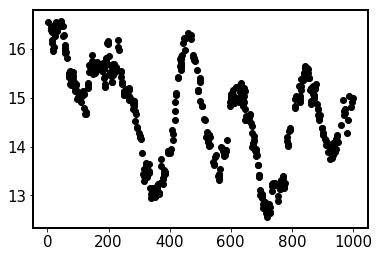

In [6]:
%matplotlib inline
N = 500
np.random.seed(41) 
t = np.sort(np.random.uniform(0, 1000, N))  
# the photometric errors drawn from uniform distribution
# between lower and upper noise value 
# those correspond to very low noise 
y_err = np.random.uniform(0.01, 0.02, len(t))
# noise = yerr * np.random.randn(len(t)) 
y_obs = model_sin_drw(t,y_err,A=1,period=200,mean=15, fP=1, fA=1)
plt.errorbar(t, y_obs, y_err,  fmt='ok', elinewidth=0.5, capsize=0)

### The simulated data : DRW nad sinusoid stored as dict <a id='simulatedData'></a>

In [ ]:
# Read in the dictionary of light curves evaluated over a denser grid ...
# loading one dic with 10 000 light curves ... 
dic = np.load('DRW_sin_time_series_denser.npy').item()

# Read in the light curve, and 
# use either the sinusoidal component, 
# the DRW component, or both -  
# it is stored as a dictionary, 
# so that we can choose to add Gaussian noise component 
# or not  


fA_values = np.linspace(0.01,2,100)
sigma_in = 0.2
SF_inf = sigma_in * np.sqrt(2) 
A_values = fA_values * SF_inf
A_bounds = [0.1 * min(A_values), 5*max(A_values)]

tau_in = 100 
fP_values = np.linspace(0.01,100,100)
period=  fP_values * tau_in
omega_values = 2*np.pi / period
omega_bounds = [0.1 * min(omega_values), 10*max(omega_values)]
tau_bounds = [1,1000]
sigma_bounds = [0.001, 10]

A_in=[] ;  omega_in = [] ; tau_in=[]; sigma_in = []
A_fit=[]; omega_fit=[]; tau_fit = []; sigma_fit = []

N_iter = len(dic.keys())
#for i in range(N_iter):
i = 1000
#dic = np.load(fname).item()
if i % 100 == 0 :
    print(i,'/',N_iter)
y_DRW = dic[i]['DRW']
y_sin = dic[i]['sinusoid']
noise = dic[i]['noise']
yerr = dic[i]['err']
sigma = dic[i]['sigma']
SF_inf = sigma * np.sqrt(2) 
tau = dic[i]['tau']
A = dic[i]['fA'] * SF_inf
period = dic[i]['fP'] * tau
time = dic[i]['time']

A_in.append(A)
omega = 2*np.pi / period 
omega_in.append(omega)
tau_in.append(tau)
sigma_in.append(sigma)



### Benchmarking GatsPy for fitting sinusoidal oscillation on top of DRW  <a id='gatspyBenchmark'></a>
[ Go to top ](#toc)

In [336]:
from gatspy.periodic import LombScargleAstroML

# compared to LombScargle, this implementation is
# both faster and more memory-efficient.

# computing best period using LS periodogram
# implemented in GatsPy
from gatspy.periodic import LombScargleFast 
def fit_gatspy(t,y_obs,yerr):
    ls = LombScargleAstroML().fit(t,y_obs,yerr)
    ls.optimizer.period_range = (100,250)
    return ls.best_period


In [253]:
Pfit = []
texec = []
Nnum = []
Nvals  = np.arange(50,1500,50)

np.random.seed(41)  # The
for i in range(1):
    for N in Nvals : 
        Nnum.append(N)
        t = np.sort(np.random.uniform(0, 1000, N))  
        # the photometric errors drawn from uniform distribution
        # between lower and upper noise value 
        # those correspond to very low noise 
        yerr = np.random.uniform(0.01, 0.02, len(t))
        # noise = yerr * np.random.randn(len(t)) 
        y_obs = model_sin_drw(t,yerr)


        # fitting for best period using Gatspy 
        start = time.time()
        fit_period = fit_gatspy(t,y_obs,yerr)
        end = time.time()
        dt = end  - start 

        Pfit.append(fit_period)
        texec.append(dt)
print('####### DONE ####### ')

Finding optimal frequency:
 - Estimated peak width = 0.00657
 - Using 5 steps per peak; omega_step = 0.00131
 - User-specified period range:  99 to 2.5e+02
 - Computing periods at 30 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00643
 - Using 5 steps per peak; omega_step = 0.00129
 - User-specified period range:  99 to 2.5e+02
 - Computing periods at 31 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
Finding optimal frequency:
 - Estimated peak width = 0.00639
 - Using 5 steps per peak; omega_step = 0.00128
 - User-specified period range:  99 to 2.5e+02
 - Computing periods at 31 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00634
 - Using 5 steps per peak; omega_step = 0.00127
 - User-specified period range:  99 to 2.5e+02
 - Computing periods at 31 steps
Zooming-in on 5 candidate peaks:
 - Compu

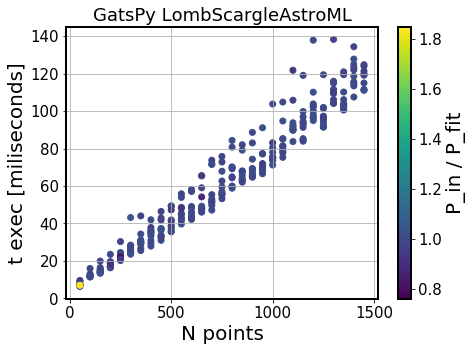

In [251]:
fig,ax = plt.subplots(1,1, figsize=(7,5))
ax.set_title('GatsPy LombScargleAstroML')
ax.set_xlabel('N points')
ax.set_ylabel('t exec [miliseconds]')
cbar = ax.scatter(Nnum, np.array(texec)*1000, c=200/np.array(Pfit))
plt.colorbar(cbar, label = 'P_in / P_fit')
ax.grid()
plt.savefig('GatsPy_sinusoid_with_DRW_benchmark.png', bbox_inches='tight')

Note: here the DRW params are  fixed  : sigma0 = A ,  tau = period  , 
        sinusoidal params are fixed:  A=1,  period = 200,
            sampling random uniform between 0 and 1000, so that there are at least 5 oscillations. We are solely calculating the LombScargle periodgram, using the built-in finding of the best-fitting period. We constrain the period finding range to be between 100 and 250.   We only vary the number of points in the simulated observation, sampling between N0=50 and N1=1500, with dN = 50.  We repeat the same N grid 10 times, so that in the end we plot 10 * ((1500-50)/50) = 10 * 29 = 290 .

### AstroPy :  Implement False Alarm Probability  <a id='astropyImplement'></a>

[Go to top](#toc)
It seems not readily available in GatsPy....

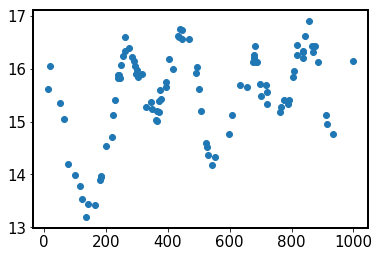

In [7]:
%matplotlib inline
N=100
t = np.sort(np.random.uniform(0, 1000, N))  
y_err = np.random.uniform(0.01, 0.02, len(t)) 
y_obs = model_sin_drw(t,y_err)
plt.scatter(t,y_obs)

Try AstroML  - the problem is that the uiser needs to specify frequencies at which to evaluate ....  


In [340]:
from astroML.time_series import lomb_scargle


Try AstroPy : 

In [8]:

ls = LombScargle(t, y_obs, y_err)
freq, power = ls.autopower()

In [9]:
print(power.max())

0.434690564143


In [11]:
ls.false_alarm_probability(power.max())

1.4142808061426154e-09

Example below is from the astropy docs https://github.com/astropy/astropy/blob/master/docs/stats/lombscargle.rst . Note that since we're considering RR Lyrae, we restrict frequencies by only scanning the range corresponding to periods between 0.2 and 1.2 days, characteristic for RR Lyr : fMin = 1/1.2 , fMax = 1/0.2 

In [22]:
ls.autopower??


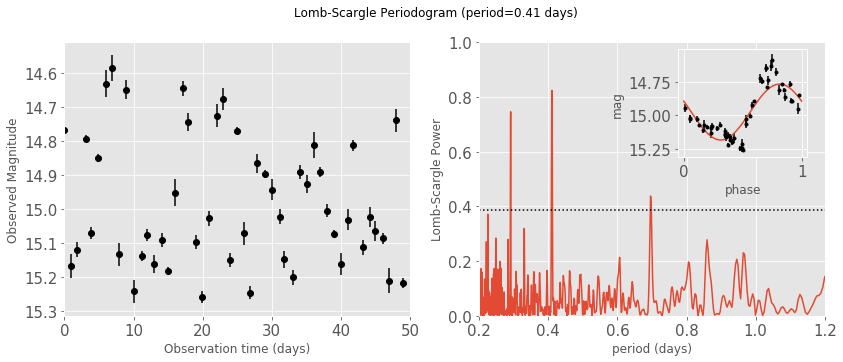

In [12]:
#astropy docs example

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from astropy.stats import LombScargle


def simulated_data(N, rseed=2, period=0.41, phase=0.0):
    """Simulate data based from a pre-computed empirical fit"""

    # coefficients from a 5-term Fourier fit to SDSS object 1019544
    coeffs = [-0.0191, 0.1375, -0.1968, 0.0959, 0.075,
              -0.0686, 0.0307, -0.0045, -0.0421, 0.0216, 0.0041]

    rand = np.random.RandomState(rseed)
    t = phase + np.arange(N, dtype=float)
    t += 0.1 * rand.randn(N)
    dmag = 0.01 + 0.03 * rand.rand(N)

    omega = 2 * np.pi / period
    n = np.arange(1 + len(coeffs) // 2)[:, None]

    mag = (15 + dmag * rand.randn(N)
           + np.dot(coeffs[::2], np.cos(n * omega * t)) +
           + np.dot(coeffs[1::2], np.sin(n[1:] * omega * t)))

    return t, mag, dmag


# generate data and compute the periodogram
t, mag, dmag = simulated_data(50)
ls = LombScargle(t, mag, dmag, normalization='standard')
100,250
freq, PLS = ls.autopower(minimum_frequency=1 / 1.2,
                         maximum_frequency=1 / 0.2)
best_freq = freq[np.argmax(PLS)]
phase = (t * best_freq) % 1

# compute the best-fit model
phase_fit = np.linspace(0, 1)
mag_fit = ls.model(t=phase_fit / best_freq,
                   frequency=best_freq)

# set up the figure & axes for plotting
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Lomb-Scargle Periodogram (period=0.41 days)')
fig.subplots_adjust(bottom=0.12, left=0.07, right=0.95)
inset = fig.add_axes([0.78, 0.56, 0.15, 0.3])

# plot the raw data
ax[0].errorbar(t, mag, dmag, fmt='ok', elinewidth=1.5, capsize=0)
ax[0].invert_yaxis()
ax[0].set(xlim=(0, 50),
          xlabel='Observation time (days)',
          ylabel='Observed Magnitude')

# plot the periodogram
ax[1].plot(1. / freq, PLS)
ax[1].set(xlabel='period (days)',
          ylabel='Lomb-Scargle Power',
          xlim=(0.2, 1.2),
          ylim=(0, 1));

# plot the false-alarm levels
z_false = ls.false_alarm_level(0.01, maximum_frequency=1 / 0.2,
                               method='baluev')
ax[1].axhline(z_false, linestyle='dotted', color='black')

# plot the phased data & model in the inset
inset.errorbar(phase, mag, dmag, fmt='.k', capsize=0)
inset.plot(phase_fit, mag_fit)
inset.invert_yaxis()
inset.set_xlabel('phase')
inset.set_ylabel('mag')


Adapt it to my simulation  :
    
    

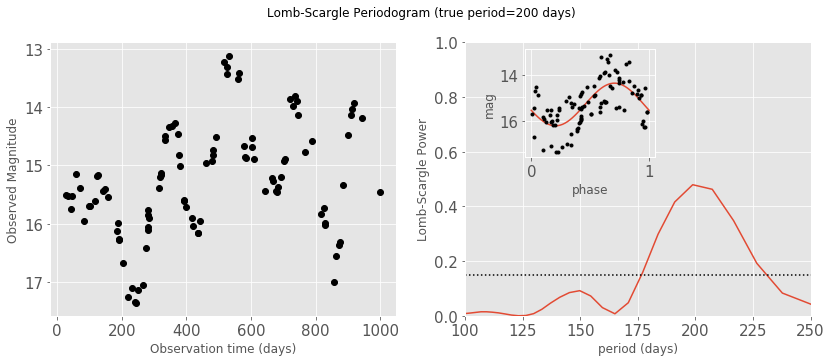

In [32]:
np.random.seed(41)
N=100
t = np.sort(np.random.uniform(0, 1000, N))  
dmag = np.random.uniform(0.01, 0.02, len(t)) 
mag = model_sin_drw(t,dmag,A=1, period=200,mean=15)
minimum_period,  maximum_period = 100,250


ls = LombScargle(t, mag, dmag, normalization='standard')
freq, PLS = ls.autopower(minimum_frequency=1 / maximum_period,
                         maximum_frequency=1 / minimum_period)
best_freq = freq[np.argmax(PLS)]
phase = (t * best_freq) % 1

# compute the best-fit model
phase_fit = np.linspace(0, 1)
mag_fit = ls.model(t=phase_fit / best_freq,
                   frequency=best_freq)

# set up the figure & axes for plotting
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Lomb-Scargle Periodogram (true period=200 days)')
fig.subplots_adjust(bottom=0.12, left=0.07, right=0.95)
inset = fig.add_axes([0.62, 0.56, 0.15, 0.3])

# plot the raw data
ax[0].errorbar(t, mag, dmag, fmt='ok', elinewidth=1.5, capsize=0)
ax[0].invert_yaxis()
ax[0].set(#xlim=(0, 50),
          xlabel='Observation time (days)',
          ylabel='Observed Magnitude')

# plot the periodogram
ax[1].plot(1. / freq, PLS)
ax[1].set(xlabel='period (days)',
          ylabel='Lomb-Scargle Power',
          xlim=(minimum_period, maximum_period),
          ylim=(0, 1));

# plot the false-alarm levels
z_false = ls.false_alarm_level(0.01, maximum_frequency=1 / minimum_period,
                               method='baluev')
ax[1].axhline(z_false, linestyle='dotted', color='black')

# plot the phased data & model in the inset
inset.errorbar(phase, mag, dmag, fmt='.k', capsize=0)
inset.plot(phase_fit, mag_fit)
inset.invert_yaxis()

inset.set_xlabel('phase')
inset.set_ylabel('mag')




Loop over many lightcurves changing N, as before, and checking how fast is the AstroPy implementation, when we do / don't ask for the FAP .

## Test:  benchmark AstroPy LS , with frequency bounds, changing N points <a id='astropyBenchmark'></a>

[Go to top](#toc)

Effect of changing period boundaries in AstroPy.stats.LombScargle in : 
  * [Single light curve ](#astropySingleLC)
  * [Many LCs, random sampling: effect of period bounds](#astropyRandom)
  * [Many LCs, S82 sampling](#astropyS82)

In these two tests we keep the light curve length fixed at 1000 days, period of sinusoidl oscillation is 200 days, we keep changing the number of points randomly sampling space. Do 100 LS fits for light curve of given length. The errors and Gaussian noise are negligible. True period is 200 days. Combined sinusoidal and DRW signal. Vary frequency bounds in ls.autopower(): 
 * period from 100 to 250 days 
 * period from 0.01 to 1000 days 
 * no bounds 

### First : check on one light curve how limits on frequency affect the period inferred from LS <a id='astropySingleLC'></a>

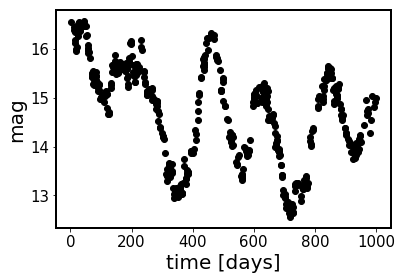

In [9]:
from astropy.stats import LombScargle
# model sinusoid + DRW 
N = 500
np.random.seed(41) 
t = np.sort(np.random.uniform(0, 1000, N))  
dmag = np.random.uniform(0.01, 0.02, len(t))
mag = model_sin_drw(t,dmag)
fig,ax = plt.subplots(1,1)
ax.errorbar(t, mag, dmag, fmt='ok', elinewidth=1.5, capsize=0)
ax.set_xlabel('time [days]')
ax.set_ylabel('mag')
plt.savefig('_DRW_sin_example_500pts.png', bbox_inches='tight')

Narrow period range : 

best period is  199.537648489
fap for this period is  9.94586394143e-59


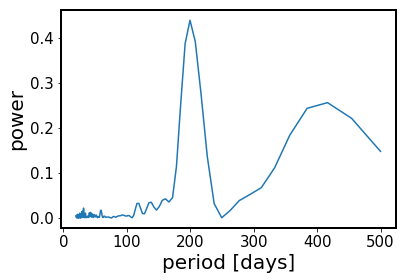

In [153]:
# calculate LS
ls = LombScargle(t, mag, dmag, normalization='standard')

minimum_period = 20 ;   maximum_period = 500
freq, power = ls.autopower(minimum_frequency=1 / maximum_period,
                               maximum_frequency=1 / minimum_period)
plt.xlabel('period [days]')
plt.ylabel('power')
plt.plot(1 / freq, power)
best_freq = freq[np.argmax(power)]
best_period = 1.0 / best_freq
print('best period is ', best_period)
fap = ls.false_alarm_probability(power.max())
print('fap for this period is ', fap)
plt.savefig('_setup1a_LS_500_pts.png', bbox_inches='tight')

Wider period range : 

best period is  199.384005995
fap for this period is  9.94360973521e-59


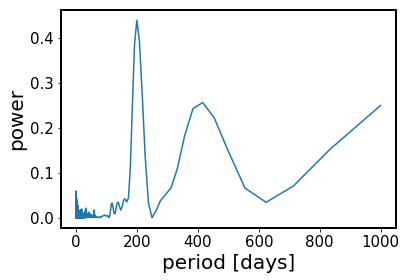

In [154]:
# calculate LS
ls = LombScargle(t, mag, dmag, normalization='standard')
minimum_period = 0.01 ;   maximum_period = 1000

freq, power = ls.autopower(minimum_frequency=1 / maximum_period,
                               maximum_frequency=1 / minimum_period)
plt.xlabel('period [days]')
plt.ylabel('power')
plt.plot(1 / freq, power)
best_freq = freq[np.argmax(power)]
best_period = 1.0 / best_freq
print('best period is ', best_period)
fap = ls.false_alarm_probability(power.max())
print('fap for this period is ', fap)
plt.savefig('_setup1c_LS_500_pts.png', bbox_inches='tight')

No period bounds: 

best period is  767.722424753
fap for this period is  5.5500621607e-56


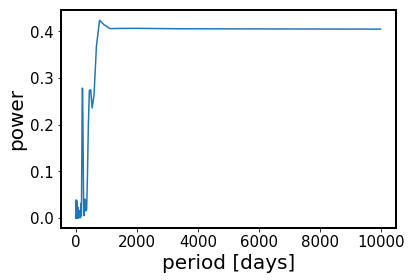

In [43]:
freq, power = ls.autopower(minimum_frequency=None,
                               maximum_frequency=None)
plt.xlabel('period [days]')
plt.ylabel('power')
plt.plot(1 / freq, power)
best_freq = freq[np.argmax(power)]
best_period = 1.0 / best_freq
print('best period is ', best_period)
fap = ls.false_alarm_probability(power.max())
print('fap for this period is ', fap)

Whew,  seems that without better constraints on period , the calculation is not as good .... 

Lets have one more look on GatsPy : 

In [44]:
from gatspy.periodic import LombScargleAstroML
ls = LombScargleAstroML().fit(t,mag,dmag)
ls.optimizer.period_range = (100,250)
ls.best_period

Finding optimal frequency:
 - Estimated peak width = 0.0063
 - Using 5 steps per peak; omega_step = 0.00126
 - User-specified period range:  1e+02 to 2.5e+02
 - Computing periods at 31 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


207.14128519057761

In [148]:
# It doesn't do that great -  it takes much longer to compute...
ls = LombScargleAstroML().fit(t,mag,dmag)
ls.optimizer.period_range = (0.01, 1000)
ls.best_period 

NameError: name 'LombScargleAstroML' is not defined

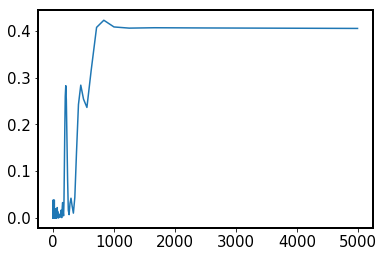

In [64]:
period,power = ls.periodogram_auto()
plt.plot(period , power)

It looks the same as when I  use AstroPy without specifying minimum / maximum frequency  ... But at least AstroPy doesn't protest when I set eg. max period to be greater than the data length ... 

### Second : benchmark changing period limits   <a id='astropyRandom'></a>

In [10]:
# Define a fitting function  :

def fit_astropy(t,mag,dmag, returnFAP = False,
                minimum_frequency = 1/250,  maximum_frequency = 1/100):
    ls = LombScargle(t, mag, dmag, normalization='standard')
    freq, power = ls.autopower(minimum_frequency=minimum_frequency, 
                               maximum_frequency=maximum_frequency)
    best_freq = freq[np.argmax(power)]
    best_period = 1.0 / best_freq
    
    if returnFAP : 
        fap = ls.false_alarm_probability(power.max())
        return best_period, fap
    else:
        
        return best_period, None



Compare with / without FAP : is there much difference   with narrow period limits ? 

In [12]:
ls = LombScargle(t, y_obs, y_err, normalization='standard')
freq, power = ls.autopower(minimum_frequency=1/maximum_period, 
                           maximum_frequency=1/minimum_period)

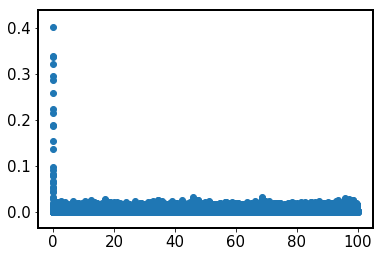

In [14]:
%matplotlib inline
plt.scatter(freq, power)

In [11]:
# Test the main fitting part 
N = 1000 
t = np.sort(np.random.uniform(0, 1000, N))  
y_err = np.random.uniform(0.01, 0.02, len(t))
y_obs = model_sin_drw(t,y_err)

minimum_period, maximum_period = 0.01, 1000
# fitting for best period using Gatspy 
start = time.time()
returnFAP = True
if returnFAP  : # Trial 2 : with FAP  
    fit_period, fap_calc = fit_astropy(t,y_obs,y_err, 
                            returnFAP=returnFAP,
                            minimum_frequency = 1/maximum_period,  
                             maximum_frequency = 1/minimum_period)
print(fit_period, fap_calc)

199.152562339 1.86291862206e-107


In [ ]:
# First store the LCs at each number, so that we are fitting the same light 
# curve .... 
#simulated_LC = {}




In [107]:
import time
res_dic = {'noFAP':{}, 'withFAP':{}}

# Setup 1 : narrow period range 
#minimum_period, maximum_period = 100, 250 

# Setup 1a : wider period range 
#minimum_period, maximum_period = 20, 500

# Setup 2: wide period range 
minimum_period, maximum_period = 0.01, 1000


Nvals  = np.arange(50,1500,50)  
Niterations = 10
verbose = False
 # Keeping the random number generator seed the same, 
# so that the only thing that changes is the number of points 

for returnFAP in [False, True] : 
    if returnFAP is False:
        keyFAP  = 'noFAP'
    else:
        keyFAP = 'withFAP'
    
    # initialize the temporary storage arrays :  ensures
    # there is no overhead, as adding to a list is very quck ,
    # unlike numpy.append() as far as I know 
    Pfit = []
    texec = []
    Nnum = []
    FAP = []
    for i in range(Niterations):
        if verbose:
            print('### iteration  ', i)
        for N in Nvals: # [1000]:#Nvals : 
            Nnum.append(N)
            t = np.sort(np.random.uniform(0, 1000, N))  
            y_err = np.random.uniform(0.01, 0.02, len(t))
            y_obs = model_sin_drw(t,y_err)

            #plt.scatter(t,y_obs+2*i)
            # fitting for best period using Gatspy 
            start = time.time()
            
            # fap_calc is None if returnFAP is False 
            fit_period, fap_calc = fit_astropy(t,y_obs,y_err, 
                                    returnFAP=returnFAP,
                                    minimum_frequency = 1/maximum_period,  
                                     maximum_frequency = 1/minimum_period)

            end = time.time()
            dt = end  - start 

            Pfit.append(fit_period)
            if returnFAP:
                FAP.append(fap_calc)
            texec.append(dt)
            if verbose:
                print(keyFAP, N, i, fit_period,fap_calc,dt*1000)
    print('/n')   
    print('####### DONE #######  : ', keyFAP)
    res_dic[keyFAP]['Pfit'] = Pfit
    res_dic[keyFAP]['texec'] = texec
    res_dic[keyFAP]['Nnum'] = Nnum
    res_dic[keyFAP]['Pfit'] = Pfit
    res_dic[keyFAP]['FAP'] = FAP


print_part = False
if print_part : 
    keyFAP = 'withFAP'
    
    texec =  res_dic[keyFAP]['texec'] 
    Nnum = res_dic[keyFAP]['Nnum'] 
    fig,ax = plt.subplots(1,1, figsize=(7,5))
    ax.set_title('AstroPy LombScargle')
    ax.set_xlabel('N points')
    ax.set_ylabel('t exec [miliseconds]')
    cbar = ax.scatter(Nnum, np.array(texec)*1000, c=200/np.array(Pfit))
    plt.colorbar(cbar, label = 'P_in / P_fit')
    ax.grid()
    
    #plt.savefig('AstroPy_sinusoid_with_DRW_benchmark_'+keyFAP+'.png', 
    #           bbox_inches='tight')




/n
####### DONE #######  :  noFAP
/n
####### DONE #######  :  withFAP


In [108]:
np.median(res_dic['withFAP']['Pfit'])

199.84511311301884

In [109]:
from astroML.stats import sigmaG
sigmaG(res_dic['withFAP']['Pfit'])

312.40110367195967

(array([   3.,    0.,    0.,    0.,    0.,  166.,   38.,    0.,    0.,
           0.,    0.,    1.,    1.,    2.,    3.,    0.,    2.,    0.,
          10.,    0.,    0.,    9.,    0.,    0.,   10.,    0.,    0.,
           0.,    0.,   45.]),
 array([  5.20667588e-05,   1.66716998e-01,   3.33381929e-01,
          5.00046860e-01,   6.66711791e-01,   8.33376722e-01,
          1.00004165e+00,   1.16670658e+00,   1.33337152e+00,
          1.50003645e+00,   1.66670138e+00,   1.83336631e+00,
          2.00003124e+00,   2.16669617e+00,   2.33336110e+00,
          2.50002603e+00,   2.66669096e+00,   2.83335590e+00,
          3.00002083e+00,   3.16668576e+00,   3.33335069e+00,
          3.50001562e+00,   3.66668055e+00,   3.83334548e+00,
          4.00001041e+00,   4.16667534e+00,   4.33334028e+00,
          4.50000521e+00,   4.66667014e+00,   4.83333507e+00,
          5.00000000e+00]),
 <a list of 1 Patch objects>)

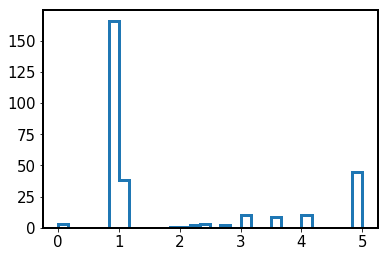

In [118]:
#plt.hist(res_dic['noFAP']['Pfit'])
plt.hist(np.array(res_dic['withFAP']['Pfit'])/200, 
         histtype='step', lw=3, bins=30)

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


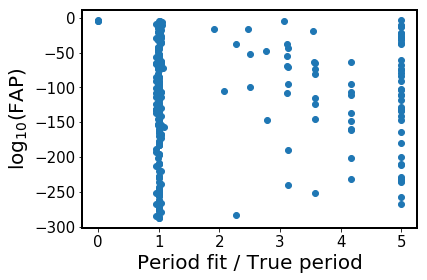

In [131]:
col0 = np.array(res_dic['withFAP']['Pfit'])/200
col1 = np.log10(np.array(res_dic['withFAP']['FAP']))
plt.scatter(col0,col1)
plt.xlabel('Period fit / True period')
plt.ylabel(r'$\log_{10}(\mathrm{FAP})$')
plt.savefig('_setup1c_P_vs_FAP.png', bbox_inches='tight')

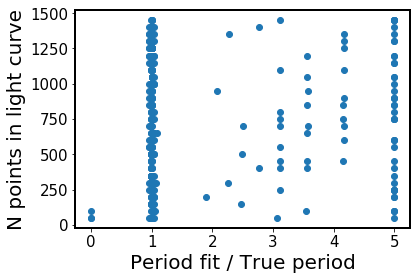

In [130]:
col0 = np.array(res_dic['withFAP']['Pfit'])/200
col1 = np.array(res_dic['withFAP']['Nnum'])
plt.scatter(col0,col1)
plt.xlabel('Period fit / True period')
plt.ylabel('N points in light curve')
plt.savefig('_setup1c_P_vs_N.png', bbox_inches='tight')

In [38]:
np.save('res_dic_FAP_benchmark_setup1a', res_dic)

(array([  37.,  130.,   72.,    6.,    5.,    1.,    0.,    1.,    1.,    1.]),
 array([ 0.96115613,  1.06190226,  1.16264839,  1.26339452,  1.36414065,
         1.46488678,  1.56563292,  1.66637905,  1.76712518,  1.86787131,
         1.96861744]),
 <a list of 10 Patch objects>)

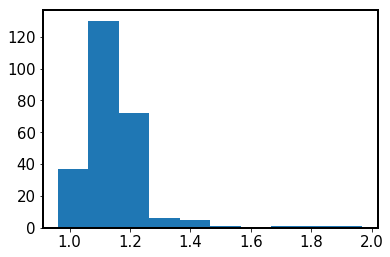

In [139]:
t=np.array(res_dic['withFAP']['texec'])
plt.hist(t[t<2])

In [135]:
fig,ax  = plt.subplots(1,1)
ax.scatter(np.array(res_dic['withFAP']['Pfit']) / 200, np.log10(res_dic['withFAP']['FAP']))
ax.set_xlabel('Period at max LS power / Input period ')
ax.set_ylabel(r'$\log_{10}(\mathrm{FAP})$')
plt.savefig('setup1a_astroPy_LS_benchmark_'+str(Niterations)+'_FAP.png', 
            bbox_inches='tight')

array([  50,  100,  150,  200,  250,  300,  350,  400,  450,  500,  550,
        600,  650,  700,  750,  800,  850,  900,  950, 1000, 1050, 1100,
       1150, 1200, 1250, 1300, 1350, 1400, 1450,   50,  100,  150,  200,
        250,  300,  350,  400,  450,  500,  550,  600,  650,  700,  750,
        800,  850,  900,  950, 1000, 1050, 1100, 1150, 1200, 1250, 1300,
       1350, 1400, 1450,   50,  100,  150,  200,  250,  300,  350,  400,
        450,  500,  550,  600,  650,  700,  750,  800,  850,  900,  950,
       1000, 1050, 1100, 1150, 1200, 1250, 1300, 1350, 1400, 1450,   50,
        100,  150,  200,  250,  300,  350,  400,  450,  500,  550,  600,
        650,  700,  750,  800,  850,  900,  950, 1000, 1050, 1100, 1150,
       1200, 1250, 1300, 1350, 1400, 1450,   50,  100,  150,  200,  250,
        300,  350,  400,  450,  500,  550,  600,  650,  700,  750,  800,
        850,  900,  950, 1000, 1050, 1100, 1150, 1200, 1250, 1300, 1350,
       1400, 1450,   50,  100,  150,  200,  250,  3

The mean offset is  -0.0360392866463  seconds 


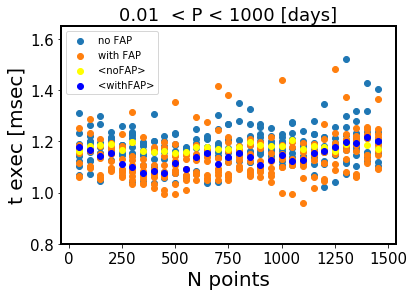

In [147]:
# convert to miliseconds  ( or not for Setup 1c )
x,y = np.array(res_dic['noFAP']['Nnum']), np.array(res_dic['noFAP']['texec'])
x1,y1 = np.array(res_dic['withFAP']['Nnum']), np.array(res_dic['withFAP']['texec'])

# Calculate medians along x
med1 = []
for v in np.unique(x1):
    mask = x1 == v 
    med1.append(np.median(y1[mask]))
    
med = []
for v in np.unique(x):
    mask = x == v 
    med.append(np.median(y[mask]))
    
# plot the comparison .... 
fig,ax = plt.subplots(1,1)
ax.scatter(x,y, label='no FAP')
ax.scatter(x1,y1, label='with FAP')
ax.scatter(Nvals, med, c='yellow',label='<noFAP>')
ax.scatter(Nvals, med1, c='blue',label='<withFAP>')
ax.set_xlabel('N points')
ax.set_ylabel('t exec [msec]')
ax.legend()
ax.set_ylim(0.8,1.65)
ax.set_title(str(minimum_period)+'  < P < ' + str(maximum_period) + ' [days]')
# Calculate the mean offset 
offset = np.mean(np.array(med1) - np.array(med))
print('The mean offset is ', offset, ' seconds ')
plt.savefig('setup1c_astroPy_LS_benchmark_'+str(Niterations)+'.png', bbox_inches='tight')

So the medians show that there is a very small difference, of the order of 0.13 miliseconds, required to calculate FAP, pretty much regardless of the number of points in the light curve .   Therefore it is worth calculating False Alarm Probability for each light curve . This holds only for narrow period range (100:250 days) - if we allow periods to be over much larger range (eg. 0.001 - 1000 days) , the calculation is much slower, and calculating FAP adds 1 second  on average , again regardless of N points per light curve . 

Focus on N= 200 points per light curve ,  but vary the amplitude of sinusoidal oscillation compared to the DRW amplitude ... 

In [184]:
import time
res_dic = {'noFAP':{}, 'withFAP':{}}

# Setup 1 : narrow period range 
#minimum_period, maximum_period = 100, 250 

# Setup 1a : wider period range 
minimum_period, maximum_period = 20, 500

# Setup 2: wide period range 
#minimum_period, maximum_period = 0.01, 1000

Niterations = 100
verbose = True
 # Keeping the random number generator seed the same, 
# so that the only thing that changes is the number of points 
fAvalues = np.linspace(0.001,3,100)

for returnFAP in [False, True] : 
    if returnFAP is False:
        keyFAP  = 'noFAP'
    else:
        keyFAP = 'withFAP'
    
    # initialize the temporary storage arrays :  ensures
    # there is no overhead, as adding to a list is very quck ,
    # unlike numpy.append() as far as I know 
    Pfit = []
    texec = []
    fAvals = []
    FAP = []
    for i in range(Niterations):
        if verbose:
            print('### iteration  ', i)
        N = 200
        for fA in fAvalues : 
            fAvals.append(fA)
            t = np.sort(np.random.uniform(0, 1000, N))  
            y_err = np.random.uniform(0.01, 0.02, len(t))
            #(t,y_err,A=1,period=200,mean=15, fP=1, fA=1)
            y_obs = model_sin_drw(t,y_err,fA=fA)

            #plt.scatter(t,y_obs+2*i)
            # fitting for best period using Gatspy 
            start = time.time()

            # fap_calc is None if returnFAP is False 
            fit_period, fap_calc = fit_astropy(t,y_obs,y_err, 
                                    returnFAP=returnFAP,
                                    minimum_frequency = 1/maximum_period,  
                                     maximum_frequency = 1/minimum_period)

            end = time.time()
            dt = end  - start 

            Pfit.append(fit_period)
            
            if returnFAP:
                FAP.append(fap_calc)
            texec.append(dt)
            if verbose:
                print(keyFAP, N, i, fit_period,fap_calc,dt*1000)
        # store in dict
        print('/n')   
        print('####### DONE #######  : ', keyFAP)
        res_dic[keyFAP]['Pfit'] = Pfit
        res_dic[keyFAP]['texec'] = texec
        res_dic[keyFAP]['fAvals'] = fAvals
        res_dic[keyFAP]['FAP'] = FAP




/n
####### DONE #######  :  noFAP
/n
####### DONE #######  :  noFAP
/n
####### DONE #######  :  noFAP
/n
####### DONE #######  :  noFAP
/n
####### DONE #######  :  noFAP
/n
####### DONE #######  :  noFAP
/n
####### DONE #######  :  noFAP
/n
####### DONE #######  :  noFAP
/n
####### DONE #######  :  noFAP
/n
####### DONE #######  :  noFAP
/n
####### DONE #######  :  noFAP
/n
####### DONE #######  :  noFAP
/n
####### DONE #######  :  noFAP
/n
####### DONE #######  :  noFAP
/n
####### DONE #######  :  noFAP
/n
####### DONE #######  :  noFAP
/n
####### DONE #######  :  noFAP
/n
####### DONE #######  :  noFAP
/n
####### DONE #######  :  noFAP
/n
####### DONE #######  :  noFAP
/n
####### DONE #######  :  noFAP
/n
####### DONE #######  :  noFAP
/n
####### DONE #######  :  noFAP
/n
####### DONE #######  :  noFAP
/n
####### DONE #######  :  noFAP
/n
####### DONE #######  :  noFAP
/n
####### DONE #######  :  noFAP
/n
####### DONE #######  :  noFAP
/n
####### DONE #######  :  noFAP
/n
####### DON

In [190]:
plt.hexbin?

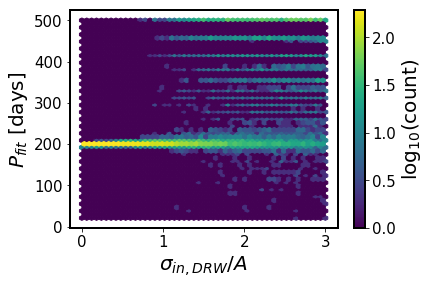

In [199]:
plot = plt.hexbin(res_dic['withFAP']['fAvals'], res_dic['withFAP']['Pfit'],
           gridsize=50, bins='log')# ,c=)
plt.colorbar(plot, label=r'$\log_{10}{(\mathrm{count})}$')
plt.xlabel(r'$\sigma_{in, DRW}  / A$')
plt.ylabel(r'$P_{fit}$'+' [days]')
plt.savefig('_setup2_N-200_vary_fA.png', bbox_inches='tight')

0.001
0.334222222222
0.667444444444
1.00066666667
1.33388888889
1.66711111111
2.00033333333
2.33355555556
2.66677777778
3.0


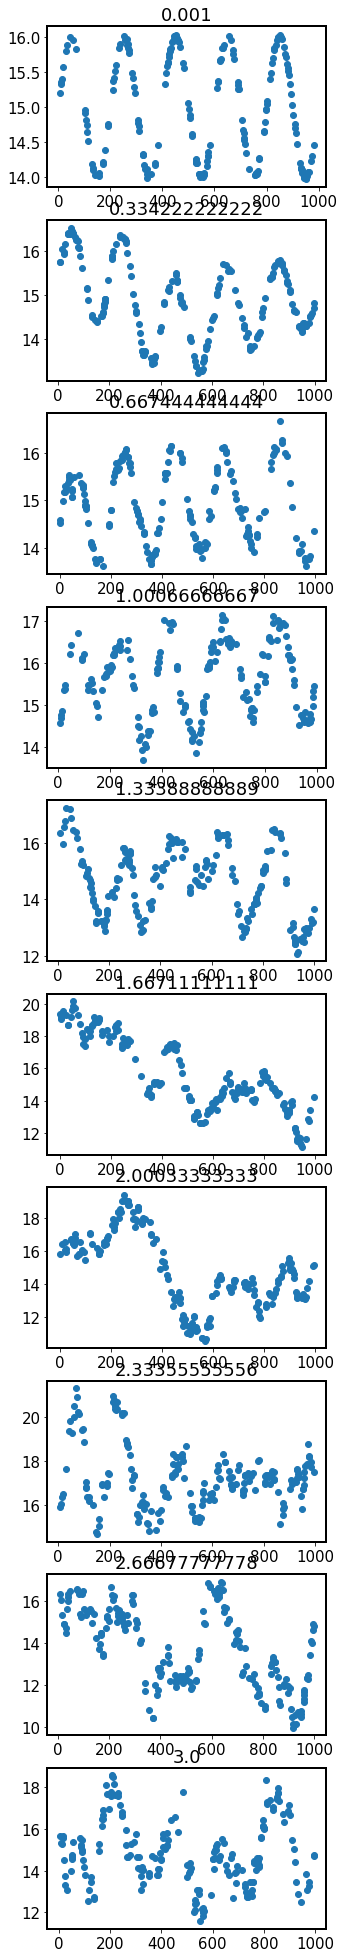

In [180]:
N=200
fig,ax  = plt.subplots(10,1, figsize=(5,35))
i = 0 
for fA in np.linspace(0.001,3,10) : 
    print(fA)
    t = np.sort(np.random.uniform(0, 1000, N))  
    y_err = np.random.uniform(0.01, 0.02, len(t))
    #(t,y_err,A=1,period=200,mean=15, fP=1, fA=1)
    y_obs = model_sin_drw(t,y_err,fA=fA)
    ax[i].scatter(t,y_obs)
    ax[i].set_title(str(fA))
    i += 1 


### Third : benchmark using S82 sampling, changing period limits <a id='astropyS82'></a>

Read in the Carbon Stars 

photometry_ugriz_233439.64+011515.7IN2P3.txt


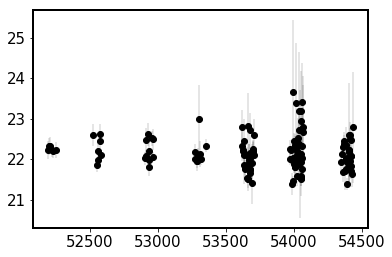

In [223]:
import os 
lcDir = '../../SDSS_S82_FP_research/code/Stripe82_dCs_lc/'
fnames = os.listdir(lcDir)
lc = Table.read(lcDir+fnames[0], format='ascii')

# illustrate the LC
f = 'u'
mask = lc['filter'].data == f
t,mag,dmag = lc['mjd'][mask].data,  lc['psfMagDered'][mask].data, lc['psfMagErr'][mask].data
plt.errorbar(t,mag,dmag,  fmt='ok', elinewidth=0.2, capsize=0)
print(fnames[0])

In [130]:
# That's what it looks like - above we simulated the light curve 
# with period of 200, with length of 1000 days .

# Below with S82 sampling, we capture ten rather than 
# only five periods, which should help, 
# despite sparse sampling ... 

We can vary :
 * the siniusoidal amplitude  wrt DRW  , 
 * period WRT baseline , 
 * period range for LS 



First,  vary sinusoidal amplitude, keeping input period at 200 , all light curves sampled at identical SDSS cadence : 

In [217]:

# Try setup 1c, with limits from 20 to 500 : 
import time
res_dic = {'withFAP':{}}

# Setup 1 : narrow period range 
#minimum_period, maximum_period = 100, 250 

# Setup 1a : wider period range 
minimum_period, maximum_period = 20, 500

# Setup 2: wide period range 
#minimum_period, maximum_period = 0.01, 1000

Niterations = 100
verbose = False

# Keeping the random number generator seed the same, 
# so that the only thing that changes is the number of points 
fAvalues = np.linspace(0.001,3,100)
keyFAP = 'withFAP'

# initialize the temporary storage arrays :  ensures
# there is no overhead, as adding to a list is very quck ,
# unlike numpy.append() as far as I know 
Pfit = []
texec = []
fAvals = []
FAP = []
for i in range(Niterations):
    print('### iteration  ', i)
    for fA in fAvalues : 
        fAvals.append(fA)
        y_err = np.random.uniform(0.01, 0.02, len(t))
        #(t,y_err,A=1,period=200,mean=15, fP=1, fA=1)
        y_obs = model_sin_drw(t,y_err, fA=fA) # S82 cadence
    
        # fitting for best period using Gatspy 
        start = time.time()

        # fap_calc is None if returnFAP is False 
        fit_period, fap_calc = fit_astropy(t,y_obs,y_err, 
                                returnFAP=returnFAP,
                                minimum_frequency = 1/maximum_period,  
                                maximum_frequency = 1/minimum_period)

        end = time.time()
        dt = end  - start 

        Pfit.append(fit_period)
        FAP.append(fap_calc)
        texec.append(dt)
        if verbose:
            print(keyFAP, N, i, fit_period,fap_calc,dt*1000)
            
    # store in dict
    res_dic[keyFAP]['Pfit'] = Pfit
    res_dic[keyFAP]['texec'] = texec
    res_dic[keyFAP]['fAvals'] = fAvals
    res_dic[keyFAP]['FAP'] = FAP
print('/n')   
print('####### DONE #######  : ', keyFAP)



        
        
        

### iteration   0
withFAP 200 0 198.416626701 3.42655824024e-115 1.7459392547607422
withFAP 200 0 198.416626701 1.28411832729e-112 2.7740001678466797
withFAP 200 0 202.000149435 4.29874612178e-111 1.7609596252441406
withFAP 200 0 198.416626701 6.72954365047e-103 2.229928970336914
withFAP 200 0 198.416626701 1.37477958804e-118 2.446889877319336
withFAP 200 0 198.416626701 3.26422033697e-93 2.1250247955322266
withFAP 200 0 198.416626701 3.23035278122e-101 1.977682113647461
withFAP 200 0 198.416626701 4.69530272046e-95 1.6770362854003906
withFAP 200 0 198.416626701 3.58247602897e-62 1.8231868743896484
withFAP 200 0 198.416626701 3.56322354657e-90 2.315998077392578
withFAP 200 0 202.000149435 2.04770413862e-78 1.6639232635498047
withFAP 200 0 198.416626701 4.17641620821e-52 2.2840499877929688
withFAP 200 0 202.000149435 1.04581024127e-61 1.7898082733154297
withFAP 200 0 202.000149435 6.10253611756e-46 2.3932456970214844
withFAP 200 0 198.416626701 1.82551132642e-36 2.5920867919921875
withF

withFAP 200 1 202.000149435 2.77617413638e-38 2.596139907836914
withFAP 200 1 440.873080585 4.22741709201e-52 2.0401477813720703
withFAP 200 1 128.01517429 5.08540328456e-29 1.7442703247070312
withFAP 200 1 205.71549407 4.93526267352e-32 1.8990039825439453
withFAP 200 1 194.958032519 4.82298493438e-27 1.786947250366211
withFAP 200 1 222.052118572 1.14070762622e-36 2.088308334350586
withFAP 200 1 440.873080585 8.2579343748e-26 1.6510486602783203
withFAP 200 1 299.299718086 1.98156946168e-39 2.8829574584960938
withFAP 200 1 424.153808546 1.57812204257e-25 2.196788787841797
withFAP 200 1 284.094935767 8.06129319271e-21 1.8320083618164062
withFAP 200 1 478.604275851 8.9621605454e-43 2.104043960571289
withFAP 200 1 440.873080585 4.59330321056e-50 1.8391609191894531
withFAP 200 1 408.656296688 1.28336494706e-20 1.8649101257324219
withFAP 200 1 478.604275851 5.88093805992e-10 2.285003662109375
withFAP 200 1 440.873080585 5.81165984261e-38 2.969980239868164
withFAP 200 1 257.892448407 1.602674

withFAP 200 2 226.549909091 2.84581542014e-15 2.4840831756591797
withFAP 200 2 284.094935767 4.01522371046e-34 1.9419193267822266
withFAP 200 2 284.094935767 1.09538817887e-06 2.3059844970703125
withFAP 200 2 500.0 1.61323311283e-18 1.8491744995117188
withFAP 200 2 440.873080585 4.52092562552e-30 1.7080307006835938
withFAP 200 2 424.153808546 6.263135761e-25 1.8792152404785156
withFAP 200 2 270.360309868 8.96832714436e-34 2.1190643310546875
withFAP 200 2 284.094935767 6.44352816059e-16 2.0368099212646484
withFAP 200 2 236.115201431 3.16509265244e-25 1.8868446350097656
withFAP 200 2 458.964519351 6.92325732451e-39 1.8610954284667969
withFAP 200 2 291.499188836 7.63247773177e-28 1.7790794372558594
withFAP 200 2 316.224053185 6.70223393462e-26 1.8718242645263672
withFAP 200 2 209.570070613 3.40082929098e-32 2.3450851440429688
withFAP 200 2 270.360309868 7.55235664492e-14 2.3238658905029297
withFAP 200 2 299.299718086 2.78042890452e-39 2.2919178009033203
withFAP 200 2 270.360309868 9.90559

withFAP 200 3 299.299718086 2.23012723377e-14 2.0563602447509766
withFAP 200 3 424.153808546 1.82291382728e-52 2.427339553833008
withFAP 200 3 458.964519351 7.65061520405e-27 2.357006072998047
withFAP 200 3 440.873080585 8.71101857679e-21 2.20489501953125
withFAP 200 3 500.0 6.79869726659e-28 1.8308162689208984
withFAP 200 3 458.964519351 7.27429494807e-48 2.2208690643310547
withFAP 200 3 226.549909091 4.63320934323e-36 1.8548965454101562
### iteration   4
withFAP 200 4 198.416626701 9.65535604096e-120 1.8498897552490234
withFAP 200 4 198.416626701 6.66738677091e-120 1.8010139465332031
withFAP 200 4 198.416626701 1.05015490709e-106 1.7538070678710938
withFAP 200 4 198.416626701 2.86694047319e-109 1.7249584197998047
withFAP 200 4 202.000149435 4.24928780221e-103 2.2852420806884766
withFAP 200 4 202.000149435 1.12014934052e-91 1.561880111694336
withFAP 200 4 198.416626701 7.68736840153e-96 1.86920166015625
withFAP 200 4 198.416626701 6.74159985304e-65 1.928091049194336
withFAP 200 4 202.

withFAP 200 5 284.094935767 7.67557129392e-20 1.5211105346679688
withFAP 200 5 128.01517429 5.49319991549e-31 1.9960403442382812
withFAP 200 5 205.71549407 2.12603558953e-47 1.6808509826660156
withFAP 200 5 198.416626701 1.15755725735e-21 1.7180442810058594
withFAP 200 5 202.000149435 2.30792519387e-20 2.034902572631836
withFAP 200 5 458.964519351 1.89906239977e-49 1.6660690307617188
withFAP 200 5 440.873080585 4.48836854841e-37 2.062082290649414
withFAP 200 5 307.529211341 9.81709366689e-29 1.5170574188232422
withFAP 200 5 129.497360539 7.32453904865e-49 1.5971660614013672
withFAP 200 5 458.964519351 8.87070921262e-25 2.092123031616211
withFAP 200 5 277.057509945 6.75874363136e-38 2.0008087158203125
withFAP 200 5 307.529211341 5.21649999431e-13 1.737833023071289
withFAP 200 5 231.233677244 1.71404613938e-47 2.1910667419433594
withFAP 200 5 394.251345514 2.12339019804e-13 1.547098159790039
withFAP 200 5 500.0 7.91102618881e-31 2.5043487548828125
withFAP 200 5 500.0 4.54376816566e-44 2.

withFAP 200 6 252.080022032 3.91365257534e-39 2.3767948150634766
withFAP 200 6 440.873080585 6.20605183825e-26 3.484964370727539
withFAP 200 6 205.71549407 2.22708503103e-25 2.3119449615478516
withFAP 200 6 458.964519351 5.52349140007e-27 2.7658939361572266
withFAP 200 6 458.964519351 4.68029607578e-43 2.665996551513672
withFAP 200 6 335.177128294 1.5057011354e-29 2.245187759399414
withFAP 200 6 478.604275851 6.80247926537e-34 3.055095672607422
withFAP 200 6 440.873080585 1.50758468028e-34 2.724170684814453
withFAP 200 6 257.892448407 4.54969290418e-19 1.8410682678222656
withFAP 200 6 307.529211341 2.33358145796e-31 2.340078353881836
withFAP 200 6 241.207276109 1.12012567169e-14 2.2499561309814453
withFAP 200 6 440.873080585 5.04434046913e-21 2.5739669799804688
withFAP 200 6 299.299718086 3.73200460894e-43 3.512144088745117
withFAP 200 6 440.873080585 6.61032215264e-45 2.662181854248047
withFAP 200 6 270.360309868 4.04278990727e-20 2.453327178955078
withFAP 200 6 270.360309868 6.815116

withFAP 200 8 198.416626701 8.08738091451e-53 2.7070045471191406
withFAP 200 8 129.497360539 2.83254280949e-35 1.8410682678222656
withFAP 200 8 202.000149435 9.04090049882e-49 1.4510154724121094
withFAP 200 8 284.094935767 3.39145785487e-24 2.023935317993164
withFAP 200 8 202.000149435 1.50740687398e-26 1.851797103881836
withFAP 200 8 270.360309868 1.21921007224e-33 1.9278526306152344
withFAP 200 8 284.094935767 8.33612549032e-22 1.7998218536376953
withFAP 200 8 440.873080585 1.90712531397e-40 1.8258094787597656
withFAP 200 8 226.549909091 1.47532936558e-27 1.8739700317382812
withFAP 200 8 440.873080585 1.09296601727e-28 1.7139911651611328
withFAP 200 8 307.529211341 1.36779194403e-20 1.8570423126220703
withFAP 200 8 458.964519351 4.95609523636e-38 1.9338130950927734
withFAP 200 8 222.052118572 3.76036247336e-19 1.5480518341064453
withFAP 200 8 478.604275851 1.19764765658e-28 1.9249916076660156
withFAP 200 8 316.224053185 8.50486547884e-31 2.1507740020751953
withFAP 200 8 129.497360539

withFAP 200 9 222.052118572 1.1557619119e-23 2.089262008666992
withFAP 200 9 316.224053185 5.02424686668e-30 2.0389556884765625
withFAP 200 9 263.979245434 8.74863537655e-17 1.7731189727783203
withFAP 200 9 299.299718086 1.58438945291e-21 1.8308162689208984
withFAP 200 9 440.873080585 3.0213139725e-42 1.7580986022949219
withFAP 200 9 458.964519351 8.7687171841e-33 2.621889114379883
withFAP 200 9 500.0 2.17179826034e-38 2.2919178009033203
withFAP 200 9 291.499188836 1.24405725268e-22 1.8041133880615234
withFAP 200 9 325.424862766 2.78843740191e-33 2.003908157348633
withFAP 200 9 478.604275851 2.83475200454e-36 1.4338493347167969
withFAP 200 9 458.964519351 1.15337245525e-52 1.7061233520507812
withFAP 200 9 335.177128294 3.99680509815e-32 1.4560222625732422
withFAP 200 9 424.153808546 4.91501093448e-38 2.073049545288086
withFAP 200 9 316.224053185 5.54938810342e-36 2.0742416381835938
withFAP 200 9 408.656296688 2.95077574052e-39 1.8410682678222656
withFAP 200 9 325.424862766 9.7310836145

withFAP 200 10 478.604275851 6.83408947582e-47 1.9519329071044922
withFAP 200 10 500.0 2.7348221498e-28 2.3069381713867188
withFAP 200 10 424.153808546 7.17617389131e-25 1.7731189727783203
withFAP 200 10 252.080022032 4.55665680598e-18 1.6510486602783203
withFAP 200 10 222.052118572 1.70300667524e-16 1.6589164733886719
withFAP 200 10 478.604275851 1.40014687496e-33 1.7228126525878906
withFAP 200 10 458.964519351 5.81000611816e-23 1.934051513671875
withFAP 200 10 325.424862766 1.58451478577e-21 1.867055892944336
### iteration   11
withFAP 200 11 198.416626701 3.32976228688e-112 2.2652149200439453
withFAP 200 11 198.416626701 8.36160420259e-120 1.7237663269042969
withFAP 200 11 198.416626701 6.50208237904e-105 1.7788410186767578
withFAP 200 11 202.000149435 2.55147461845e-105 1.5139579772949219
withFAP 200 11 198.416626701 1.69147711347e-118 2.319812774658203
withFAP 200 11 202.000149435 1.37267317194e-107 2.4051666259765625
withFAP 200 11 198.416626701 8.09610905891e-85 1.45483016967773

withFAP 200 12 252.080022032 1.78402003743e-14 1.6188621520996094
withFAP 200 12 325.424862766 4.22822534401e-10 1.979827880859375
withFAP 200 12 246.523823763 8.65037436844e-19 1.6400814056396484
withFAP 200 12 241.207276109 3.24746389709e-25 1.7399787902832031
withFAP 200 12 440.873080585 1.1313695603e-54 1.8110275268554688
withFAP 200 12 128.01517429 5.53830654982e-23 2.300262451171875
withFAP 200 12 222.052118572 1.24407089801e-16 2.5091171264648438
withFAP 200 12 252.080022032 1.04157202315e-50 2.223968505859375
withFAP 200 12 231.233677244 1.44914930376e-17 2.0148754119873047
withFAP 200 12 424.153808546 1.76768096039e-25 1.9381046295166016
withFAP 200 12 500.0 1.76902114806e-11 1.4929771423339844
withFAP 200 12 424.153808546 5.08307640314e-20 1.626729965209961
withFAP 200 12 335.177128294 6.61621327579e-23 2.0449161529541016
withFAP 200 12 458.964519351 6.79422549837e-30 2.0380020141601562
withFAP 200 12 299.299718086 2.23506747588e-39 2.3648738861083984
withFAP 200 12 325.42486

withFAP 200 13 440.873080585 6.32993786673e-42 3.2203197479248047
withFAP 200 13 246.523823763 1.41542167134e-12 1.6529560089111328
withFAP 200 13 252.080022032 4.09154367418e-24 2.440929412841797
withFAP 200 13 440.873080585 8.92474267056e-05 2.4030208587646484
withFAP 200 13 284.094935767 4.40621886612e-30 2.4919509887695312
withFAP 200 13 440.873080585 6.89240991873e-58 2.7840137481689453
withFAP 200 13 226.549909091 2.91327047727e-32 1.8990039825439453
withFAP 200 13 440.873080585 1.24288211507e-32 2.119302749633789
withFAP 200 13 458.964519351 5.52011570938e-25 2.1810531616210938
withFAP 200 13 226.549909091 1.34030947771e-25 1.9829273223876953
withFAP 200 13 440.873080585 1.40853405918e-25 1.920938491821289
withFAP 200 13 161.232720733 9.46151760131e-14 2.1638870239257812
withFAP 200 13 424.153808546 1.06010605004e-26 2.093076705932617
### iteration   14
withFAP 200 14 198.416626701 2.89789864322e-112 2.2759437561035156
withFAP 200 14 198.416626701 3.519634502e-116 1.824855804443

withFAP 200 15 424.153808546 1.4466379937e-16 4.907131195068359
withFAP 200 15 270.360309868 3.11779611517e-17 4.214048385620117
withFAP 200 15 198.416626701 5.2387474098e-23 3.407001495361328
withFAP 200 15 458.964519351 2.23056380744e-33 4.986763000488281
withFAP 200 15 284.094935767 6.73616602046e-20 2.245187759399414
withFAP 200 15 128.01517429 1.05115284466e-11 3.268003463745117
withFAP 200 15 478.604275851 4.1935298548e-49 2.5751590728759766
withFAP 200 15 194.958032519 7.19057508977e-26 4.143953323364258
withFAP 200 15 408.656296688 3.28819275597e-49 3.1180381774902344
withFAP 200 15 440.873080585 1.2516087971e-37 2.747774124145508
withFAP 200 15 246.523823763 6.034644648e-17 3.3669471740722656
withFAP 200 15 270.360309868 7.71473360148e-29 2.660989761352539
withFAP 200 15 458.964519351 1.797585869e-54 3.595113754272461
withFAP 200 15 424.153808546 2.86004461666e-25 2.271890640258789
withFAP 200 15 500.0 8.81664655611e-30 2.4518966674804688
withFAP 200 15 458.964519351 9.4667446

withFAP 200 17 198.416626701 1.07101915494e-96 2.5529861450195312
withFAP 200 17 202.000149435 1.64109473444e-58 2.454996109008789
withFAP 200 17 198.416626701 1.47520103054e-103 2.0537376403808594
withFAP 200 17 202.000149435 3.57407045068e-102 1.6121864318847656
withFAP 200 17 202.000149435 1.66816026331e-103 2.1219253540039062
withFAP 200 17 198.416626701 6.03896443588e-68 2.2630691528320312
withFAP 200 17 129.497360539 2.80996649023e-29 1.9447803497314453
withFAP 200 17 129.497360539 3.93844408551e-53 1.7459392547607422
withFAP 200 17 202.000149435 2.84690811964e-56 2.1648406982421875
withFAP 200 17 198.416626701 4.59208361317e-56 1.7192363739013672
withFAP 200 17 202.000149435 1.98740711574e-61 1.5480518341064453
withFAP 200 17 198.416626701 9.14541855626e-64 1.6350746154785156
withFAP 200 17 198.416626701 1.50963608672e-60 1.825094223022461
withFAP 200 17 478.604275851 1.3189928277e-17 1.7821788787841797
withFAP 200 17 194.958032519 5.65656493491e-24 1.6791820526123047
withFAP 20

withFAP 200 18 194.958032519 7.3817568702e-23 2.947092056274414
withFAP 200 18 440.873080585 5.66516447255e-49 1.851797103881836
withFAP 200 18 458.964519351 6.26840329331e-32 1.878976821899414
withFAP 200 18 277.057509945 1.33631859323e-16 2.056121826171875
withFAP 200 18 202.000149435 2.12506374783e-25 1.8742084503173828
withFAP 200 18 299.299718086 3.11721323121e-32 1.9381046295166016
withFAP 200 18 205.71549407 5.7150330048e-06 1.825094223022461
withFAP 200 18 198.416626701 3.77507601185e-27 1.870870590209961
withFAP 200 18 408.656296688 1.8222975198e-28 2.1109580993652344
withFAP 200 18 424.153808546 9.24688569811e-40 2.2461414337158203
withFAP 200 18 222.052118572 6.36756442536e-33 1.928091049194336
withFAP 200 18 440.873080585 1.8179887219e-40 2.0570755004882812
withFAP 200 18 257.892448407 1.59206096894e-12 1.6710758209228516
withFAP 200 18 325.424862766 6.54226436545e-21 1.653909683227539
withFAP 200 18 424.153808546 9.61302488455e-28 1.9249916076660156
withFAP 200 18 478.6042

withFAP 200 20 458.964519351 1.34016802018e-17 1.6510486602783203
withFAP 200 20 198.416626701 3.36297276485e-23 3.407001495361328
withFAP 200 20 198.416626701 6.3612298908e-36 3.622770309448242
withFAP 200 20 270.360309868 9.68433960205e-22 2.5620460510253906
withFAP 200 20 202.000149435 1.50293331148e-15 2.212047576904297
withFAP 200 20 440.873080585 3.07192909717e-16 2.5789737701416016
withFAP 200 20 270.360309868 3.50571441981e-37 1.953125
withFAP 200 20 408.656296688 4.39228540139e-17 2.622842788696289
withFAP 200 20 284.094935767 3.14433483423e-24 2.6731491088867188
withFAP 200 20 222.052118572 8.08999908407e-26 2.640247344970703
withFAP 200 20 291.499188836 1.70376855504e-36 2.3088455200195312
withFAP 200 20 198.416626701 8.73537509139e-29 1.953125
withFAP 200 20 478.604275851 2.11880002795e-30 1.6400814056396484
withFAP 200 20 202.000149435 2.3240776507e-19 2.2611618041992188
withFAP 200 20 202.000149435 6.48588989281e-28 1.741170883178711
withFAP 200 20 440.873080585 3.5145207

withFAP 200 21 458.964519351 1.54373627936e-34 2.8858184814453125
withFAP 200 21 284.094935767 1.51350766624e-20 2.808094024658203
withFAP 200 21 458.964519351 1.69212578645e-40 1.8880367279052734
withFAP 200 21 325.424862766 5.33241430669e-17 2.149820327758789
withFAP 200 21 408.656296688 4.49194698522e-16 2.1810531616210938
withFAP 200 21 458.964519351 7.05569280896e-21 2.051115036010742
withFAP 200 21 270.360309868 1.85917197364e-12 2.137899398803711
withFAP 200 21 458.964519351 1.50964146954e-38 2.148151397705078
withFAP 200 21 458.964519351 1.23173735568e-22 2.4569034576416016
withFAP 200 21 257.892448407 2.27760904779e-25 2.500295639038086
withFAP 200 21 222.052118572 6.97997970366e-07 2.0368099212646484
withFAP 200 21 236.115201431 1.12621726092e-28 2.232789993286133
withFAP 200 21 335.177128294 1.2555773219e-36 1.7709732055664062
withFAP 200 21 325.424862766 2.10391498216e-25 2.3360252380371094
withFAP 200 21 236.115201431 2.10554129453e-07 2.012968063354492
withFAP 200 21 408.

withFAP 200 23 198.416626701 6.80240102072e-109 2.456188201904297
withFAP 200 23 198.416626701 8.92767256634e-115 2.5589466094970703
withFAP 200 23 202.000149435 6.81830952094e-93 1.5881061553955078
withFAP 200 23 198.416626701 1.04078303309e-107 2.2749900817871094
withFAP 200 23 129.497360539 1.65520869755e-65 1.500844955444336
withFAP 200 23 198.416626701 1.11652417274e-100 2.4900436401367188
withFAP 200 23 129.497360539 5.56259303353e-58 2.02178955078125
withFAP 200 23 129.497360539 9.28780553551e-55 2.276897430419922
withFAP 200 23 202.000149435 3.93823334836e-50 2.457857131958008
withFAP 200 23 198.416626701 1.5664571837e-56 1.8188953399658203
withFAP 200 23 202.000149435 1.25985117731e-57 1.752614974975586
withFAP 200 23 198.416626701 6.90684932478e-60 2.312898635864258
withFAP 200 23 128.01517429 1.68087930077e-27 1.9979476928710938
withFAP 200 23 194.958032519 1.17415408215e-36 1.9938945770263672
withFAP 200 23 202.000149435 1.66915387059e-66 1.89208984375
withFAP 200 23 194.95

withFAP 200 24 440.873080585 1.18305737959e-45 1.6968250274658203
withFAP 200 24 202.000149435 7.54962038084e-19 2.032041549682617
withFAP 200 24 424.153808546 2.53824344787e-48 2.2420883178710938
withFAP 200 24 270.360309868 6.11189524499e-16 1.6198158264160156
withFAP 200 24 440.873080585 1.92926411041e-17 1.661062240600586
withFAP 200 24 424.153808546 1.1107815878e-72 1.4979839324951172
withFAP 200 24 291.499188836 3.27562517132e-35 1.6369819641113281
withFAP 200 24 217.729444442 2.04365628359e-15 1.9807815551757812
withFAP 200 24 325.424862766 7.32072234461e-27 2.0241737365722656
withFAP 200 24 231.233677244 1.19752541643e-13 1.6868114471435547
withFAP 200 24 231.233677244 5.38641427245e-35 1.6930103302001953
withFAP 200 24 424.153808546 1.33086364713e-48 1.6968250274658203
withFAP 200 24 202.000149435 2.70119862942e-28 1.638174057006836
withFAP 200 24 205.71549407 4.2664395448e-26 1.766204833984375
withFAP 200 24 236.115201431 6.03000967825e-29 1.7538070678710938
withFAP 200 24 45

withFAP 200 25 440.873080585 3.06648337345e-41 3.1490325927734375
withFAP 200 25 299.299718086 3.97432559508e-23 4.15492057800293
withFAP 200 25 205.71549407 7.33640026744e-32 3.201007843017578
withFAP 200 25 440.873080585 3.00195451648e-55 4.639863967895508
withFAP 200 25 277.057509945 4.06481538805e-15 3.9281845092773438
withFAP 200 25 316.224053185 2.01617890131e-24 3.6590099334716797
withFAP 200 25 226.549909091 2.65999649449e-17 4.590749740600586
withFAP 200 25 500.0 6.10740654709e-32 3.404855728149414
withFAP 200 25 500.0 4.9708249707e-26 4.6939849853515625
withFAP 200 25 424.153808546 8.32652814379e-28 2.336740493774414
withFAP 200 25 270.360309868 8.23797596884e-22 2.8228759765625
withFAP 200 25 440.873080585 1.10708861342e-14 2.665996551513672
withFAP 200 25 500.0 2.45467830628e-29 2.7298927307128906
withFAP 200 25 263.979245434 2.212376961e-11 3.4322738647460938
withFAP 200 25 458.964519351 2.56339929365e-34 2.9799938201904297
withFAP 200 25 252.080022032 4.53978235497e-10 2.

withFAP 200 27 500.0 1.78550120214e-38 4.234790802001953
withFAP 200 27 198.416626701 4.17850961115e-41 5.894899368286133
withFAP 200 27 129.497360539 3.69085539456e-19 3.821134567260742
withFAP 200 27 129.497360539 6.10834881675e-14 2.9740333557128906
withFAP 200 27 440.873080585 2.72120863179e-47 3.0059814453125
withFAP 200 27 226.549909091 9.59174240754e-20 2.5060176849365234
withFAP 200 27 440.873080585 1.38375240551e-31 2.440929412841797
withFAP 200 27 440.873080585 4.27926532885e-55 2.717256546020508
withFAP 200 27 424.153808546 7.0892236123e-42 4.508733749389648
withFAP 200 27 458.964519351 5.34728516269e-32 2.8188228607177734
withFAP 200 27 202.000149435 1.44810820679e-14 2.4449825286865234
withFAP 200 27 222.052118572 1.16582411325e-25 2.3870468139648438
withFAP 200 27 424.153808546 6.03039402682e-58 2.7511119842529297
withFAP 200 27 440.873080585 8.45439077653e-46 3.0469894409179688
withFAP 200 27 277.057509945 4.38189580191e-28 2.878904342651367
withFAP 200 27 440.873080585 

withFAP 200 29 202.000149435 1.13830896721e-71 2.3741722106933594
withFAP 200 29 202.000149435 1.14523972344e-52 1.5749931335449219
withFAP 200 29 198.416626701 7.98152352626e-61 1.6512870788574219
withFAP 200 29 202.000149435 6.9520883629e-44 1.6329288482666016
withFAP 200 29 198.416626701 7.62754244645e-65 1.6491413116455078
withFAP 200 29 198.416626701 5.78621672806e-61 1.6326904296875
withFAP 200 29 202.000149435 1.96585524932e-57 1.50299072265625
withFAP 200 29 458.964519351 1.19201972048e-48 1.8780231475830078
withFAP 200 29 198.416626701 2.54114957766e-52 1.7609596252441406
withFAP 200 29 198.416626701 9.77473374448e-38 1.7132759094238281
withFAP 200 29 202.000149435 1.06389523646e-57 1.8470287322998047
withFAP 200 29 198.416626701 2.009296673e-49 1.5003681182861328
withFAP 200 29 202.000149435 2.6136640238e-56 1.6870498657226562
withFAP 200 29 194.958032519 5.92646468781e-22 2.064943313598633
withFAP 200 29 198.416626701 2.79918190912e-40 2.1212100982666016
withFAP 200 29 440.8

withFAP 200 30 277.057509945 9.61175497514e-16 3.9680004119873047
withFAP 200 30 408.656296688 1.35245087085e-39 2.20489501953125
withFAP 200 30 478.604275851 3.45748935699e-33 2.813100814819336
withFAP 200 30 440.873080585 6.50185887782e-27 2.0248889923095703
withFAP 200 30 252.080022032 3.52364085922e-21 2.445697784423828
withFAP 200 30 424.153808546 1.60019369453e-31 2.246856689453125
withFAP 200 30 236.115201431 1.3744692447e-26 2.8429031372070312
withFAP 200 30 284.094935767 1.23407083718e-13 2.5222301483154297
withFAP 200 30 129.497360539 1.02221266541e-14 2.2089481353759766
withFAP 200 30 263.979245434 8.95891430585e-15 1.9342899322509766
### iteration   31
withFAP 200 31 198.416626701 1.24699497717e-112 3.1440258026123047
withFAP 200 31 198.416626701 1.4992384159e-110 2.549886703491211
withFAP 200 31 202.000149435 3.3277950894e-110 2.5038719177246094
withFAP 200 31 202.000149435 2.22751188244e-107 2.382993698120117
withFAP 200 31 198.416626701 4.57570089516e-98 3.23891639709472

withFAP 200 32 231.233677244 1.04531776753e-27 2.413034439086914
withFAP 200 32 202.000149435 6.1797374341e-29 2.875089645385742
withFAP 200 32 277.057509945 1.20581724241e-47 2.307891845703125
withFAP 200 32 241.207276109 4.39321867733e-26 1.9249916076660156
withFAP 200 32 424.153808546 3.24139342643e-35 2.192258834838867
withFAP 200 32 270.360309868 7.39258773729e-35 2.074718475341797
withFAP 200 32 277.057509945 2.43908726839e-29 2.457857131958008
withFAP 200 32 129.497360539 1.53305744087e-17 2.5141239166259766
withFAP 200 32 500.0 1.61317239491e-15 1.9311904907226562
withFAP 200 32 458.964519351 9.81931470182e-31 2.7627944946289062
withFAP 200 32 478.604275851 7.29036656616e-23 1.8999576568603516
withFAP 200 32 335.177128294 7.59103027802e-10 2.897024154663086
withFAP 200 32 241.207276109 2.47503102679e-39 3.8750171661376953
withFAP 200 32 241.207276109 4.68048766857e-10 2.779722213745117
withFAP 200 32 325.424862766 1.69048406747e-22 2.988100051879883
withFAP 200 32 394.251345514

withFAP 200 34 198.416626701 3.83958626305e-39 3.957033157348633
withFAP 200 34 226.549909091 1.49224259358e-24 2.7997493743896484
withFAP 200 34 202.000149435 5.58455837998e-53 3.5648345947265625
withFAP 200 34 458.964519351 2.44435570604e-58 2.457141876220703
withFAP 200 34 198.416626701 1.12870746893e-48 2.2389888763427734
withFAP 200 34 202.000149435 3.24259397714e-68 2.7170181274414062
withFAP 200 34 440.873080585 1.30287103198e-74 2.317190170288086
withFAP 200 34 194.958032519 1.40321111681e-19 2.730131149291992
withFAP 200 34 198.416626701 5.40313922409e-59 2.7577877044677734
withFAP 200 34 205.71549407 7.6940440835e-14 3.8309097290039062
withFAP 200 34 478.604275851 1.75945752588e-23 4.4422149658203125
withFAP 200 34 198.416626701 8.33144503173e-36 3.9758682250976562
withFAP 200 34 198.416626701 9.15448798007e-28 2.964019775390625
withFAP 200 34 198.416626701 3.69918555979e-28 2.734661102294922
withFAP 200 34 335.177128294 1.97322561872e-16 3.4499168395996094
withFAP 200 34 458

withFAP 200 35 440.873080585 4.07273588267e-28 4.0740966796875
withFAP 200 35 307.529211341 9.87763139331e-25 2.9659271240234375
withFAP 200 35 458.964519351 7.02852240032e-23 2.527952194213867
withFAP 200 35 440.873080585 2.91994024059e-21 2.4940967559814453
withFAP 200 35 307.529211341 6.10877350624e-48 2.627134323120117
withFAP 200 35 252.080022032 2.30995604917e-21 2.1686553955078125
withFAP 200 35 226.549909091 1.26056092144e-26 2.221822738647461
withFAP 200 35 252.080022032 8.26820855334e-25 1.7158985137939453
withFAP 200 35 231.233677244 4.64506261556e-17 2.9289722442626953
withFAP 200 35 291.499188836 3.12991661992e-24 2.4650096893310547
withFAP 200 35 202.000149435 1.19325787723e-42 2.6009082794189453
withFAP 200 35 291.499188836 5.24596612258e-53 2.5551319122314453
withFAP 200 35 129.497360539 1.4445322142e-18 2.5582313537597656
withFAP 200 35 236.115201431 2.85963815854e-14 2.5107860565185547
withFAP 200 35 277.057509945 1.30378124886e-51 2.8710365295410156
withFAP 200 35 44

withFAP 200 37 440.873080585 1.32386062779e-30 2.6938915252685547
withFAP 200 37 440.873080585 1.47802675844e-46 3.342866897583008
withFAP 200 37 209.570070613 2.61035135073e-43 2.515077590942383
withFAP 200 37 263.979245434 2.80096925112e-20 2.0689964294433594
withFAP 200 37 424.153808546 7.28527481611e-38 2.2499561309814453
withFAP 200 37 198.416626701 1.73867951367e-26 2.26593017578125
withFAP 200 37 440.873080585 2.1411834696e-37 2.444028854370117
withFAP 200 37 198.416626701 5.04127531548e-25 2.5129318237304688
withFAP 200 37 424.153808546 2.12864849872e-16 2.496004104614258
withFAP 200 37 316.224053185 3.33682108131e-24 2.4919509887695312
withFAP 200 37 166.019264962 7.21176662272e-15 2.4912357330322266
withFAP 200 37 408.656296688 8.90105534504e-25 2.218008041381836
withFAP 200 37 325.424862766 3.80858745722e-38 2.332925796508789
withFAP 200 37 424.153808546 1.44714761932e-69 2.6078224182128906
withFAP 200 37 284.094935767 2.65375958153e-11 3.0052661895751953
withFAP 200 37 440.

withFAP 200 38 440.873080585 3.00101553388e-16 3.9429664611816406
withFAP 200 38 226.549909091 1.73222278656e-15 2.2211074829101562
withFAP 200 38 307.529211341 4.95929470631e-32 2.154111862182617
### iteration   39
withFAP 200 39 198.416626701 3.98710599931e-112 2.5200843811035156
withFAP 200 39 198.416626701 1.54824593044e-107 1.7440319061279297
withFAP 200 39 202.000149435 1.66654915512e-108 2.8002262115478516
withFAP 200 39 198.416626701 5.65997679233e-118 2.5238990783691406
withFAP 200 39 202.000149435 9.00155550154e-108 2.7141571044921875
withFAP 200 39 198.416626701 1.15206836155e-102 2.777099609375
withFAP 200 39 198.416626701 3.52777100958e-102 3.0422210693359375
withFAP 200 39 202.000149435 1.27743046645e-89 2.297639846801758
withFAP 200 39 202.000149435 8.06891840638e-93 2.1278858184814453
withFAP 200 39 202.000149435 2.01038849609e-74 2.4330615997314453
withFAP 200 39 202.000149435 6.47440300711e-67 2.6869773864746094
withFAP 200 39 440.873080585 2.85826394994e-80 2.3322105

withFAP 200 40 478.604275851 2.96503327061e-27 3.9970874786376953
withFAP 200 40 478.604275851 5.83220753431e-48 2.386808395385742
withFAP 200 40 236.115201431 6.07426634687e-13 2.4750232696533203
withFAP 200 40 440.873080585 7.75866396025e-26 2.874135971069336
withFAP 200 40 194.958032519 4.07102357357e-38 2.9251575469970703
withFAP 200 40 291.499188836 1.15479242401e-24 2.493143081665039
withFAP 200 40 424.153808546 4.17621915672e-17 2.519845962524414
withFAP 200 40 270.360309868 4.70119314522e-06 2.8591156005859375
withFAP 200 40 246.523823763 5.50315292104e-33 2.3322105407714844
withFAP 200 40 424.153808546 1.18520800854e-11 2.5212764739990234
withFAP 200 40 217.729444442 1.63364349479e-29 2.8162002563476562
withFAP 200 40 263.979245434 1.00981057905e-17 2.6950836181640625
withFAP 200 40 500.0 5.50844301667e-20 3.3042430877685547
withFAP 200 40 284.094935767 1.20717659462e-18 3.2927989959716797
withFAP 200 40 246.523823763 4.89146093502e-33 3.1480789184570312
withFAP 200 40 458.964

withFAP 200 42 440.873080585 3.83380224758e-39 2.5281906127929688
withFAP 200 42 440.873080585 3.13365100478e-66 3.083944320678711
withFAP 200 42 202.000149435 4.70154599044e-40 2.382993698120117
withFAP 200 42 198.416626701 2.30737954955e-34 2.9439926147460938
withFAP 200 42 129.497360539 3.64087904078e-35 2.456188201904297
withFAP 200 42 202.000149435 1.35567872885e-34 2.1042823791503906
withFAP 200 42 440.873080585 3.91740687917e-48 2.500772476196289
withFAP 200 42 198.416626701 2.31475925778e-26 2.3322105407714844
withFAP 200 42 440.873080585 5.19905706863e-52 2.8688907623291016
withFAP 200 42 478.604275851 4.16644702804e-32 1.8630027770996094
withFAP 200 42 202.000149435 4.50828459135e-48 3.4308433532714844
withFAP 200 42 394.251345514 4.20705864566e-20 2.6907920837402344
withFAP 200 42 307.529211341 2.46662033297e-20 2.4089813232421875
withFAP 200 42 440.873080585 9.64706753442e-64 2.2759437561035156
withFAP 200 42 440.873080585 3.57544176951e-30 2.894163131713867
withFAP 200 42 

withFAP 200 44 202.000149435 5.86034724802e-77 1.7480850219726562
withFAP 200 44 202.000149435 2.11702609149e-74 2.0971298217773438
withFAP 200 44 129.497360539 8.61082575901e-18 1.6548633575439453
withFAP 200 44 440.873080585 1.79975646844e-61 1.89208984375
withFAP 200 44 202.000149435 1.11157546123e-44 1.8928050994873047
withFAP 200 44 198.416626701 3.16058262601e-53 1.657724380493164
withFAP 200 44 198.416626701 2.82074630675e-48 1.8210411071777344
withFAP 200 44 440.873080585 1.11400324472e-48 1.8339157104492188
withFAP 200 44 198.416626701 6.08604509977e-20 1.7421245574951172
withFAP 200 44 424.153808546 1.6567736539e-26 1.760721206665039
withFAP 200 44 440.873080585 1.50945231716e-51 1.645803451538086
withFAP 200 44 128.01517429 2.62773717454e-17 1.522064208984375
withFAP 200 44 440.873080585 2.18525860472e-62 1.7819404602050781
withFAP 200 44 198.416626701 1.93095390727e-21 1.52587890625
withFAP 200 44 478.604275851 4.05379284564e-24 1.8417835235595703
withFAP 200 44 458.9645193

withFAP 200 45 316.224053185 1.84013761042e-24 3.1709671020507812
withFAP 200 45 380.827352153 1.29399467491e-22 2.4580955505371094
withFAP 200 45 299.299718086 8.33017093565e-30 2.8181076049804688
withFAP 200 45 424.153808546 6.38111675443e-19 2.094268798828125
### iteration   46
withFAP 200 46 198.416626701 3.98707063276e-121 2.0821094512939453
withFAP 200 46 198.416626701 1.29665199167e-108 1.8248558044433594
withFAP 200 46 202.000149435 1.88391264639e-100 2.3927688598632812
withFAP 200 46 198.416626701 3.76767495792e-111 2.7091503143310547
withFAP 200 46 198.416626701 9.87067115967e-100 1.918792724609375
withFAP 200 46 198.416626701 1.81035679216e-91 2.0017623901367188
withFAP 200 46 198.416626701 1.17729487327e-87 1.795053482055664
withFAP 200 46 202.000149435 1.94304490445e-78 2.0678043365478516
withFAP 200 46 202.000149435 2.7900305832e-74 1.9299983978271484
withFAP 200 46 202.000149435 5.03905899682e-49 2.3610591888427734
withFAP 200 46 202.000149435 2.55133036819e-30 2.5651454

withFAP 200 47 202.000149435 1.35739079725e-51 2.5429725646972656
withFAP 200 47 458.964519351 3.60184486562e-36 2.8009414672851562
withFAP 200 47 458.964519351 1.97835884369e-46 3.192901611328125
withFAP 200 47 458.964519351 1.95885416889e-48 2.3648738861083984
withFAP 200 47 440.873080585 9.69914410316e-37 2.187013626098633
withFAP 200 47 194.958032519 4.01159342045e-48 2.721071243286133
withFAP 200 47 202.000149435 1.84859595897e-55 2.125978469848633
withFAP 200 47 394.251345514 7.475079077e-14 2.1729469299316406
withFAP 200 47 307.529211341 3.75647176258e-33 1.6889572143554688
withFAP 200 47 194.958032519 1.06418948178e-19 1.857757568359375
withFAP 200 47 440.873080585 1.17629696573e-46 1.8448829650878906
withFAP 200 47 335.177128294 3.39719118283e-16 2.299070358276367
withFAP 200 47 316.224053185 1.07533394408e-24 1.6329288482666016
withFAP 200 47 500.0 1.59785735331e-34 1.7688274383544922
withFAP 200 47 129.497360539 1.30578238532e-23 1.8129348754882812
withFAP 200 47 424.1538085

withFAP 200 48 478.604275851 8.17774610003e-25 1.85394287109375
withFAP 200 48 299.299718086 2.02554913706e-10 2.3107528686523438
withFAP 200 48 263.979245434 1.399953399e-32 1.8839836120605469
withFAP 200 48 226.549909091 4.9665686568e-24 1.828908920288086
withFAP 200 48 424.153808546 5.8684063111e-38 2.065896987915039
withFAP 200 48 380.827352153 4.13406952133e-13 2.360820770263672
withFAP 200 48 217.729444442 3.20586428023e-09 2.2687911987304688
withFAP 200 48 291.499188836 2.02285755017e-22 2.218008041381836
withFAP 200 48 284.094935767 7.75981272477e-36 1.8138885498046875
withFAP 200 48 440.873080585 1.25366098569e-24 1.8527507781982422
withFAP 200 48 284.094935767 4.37921854119e-14 1.9919872283935547
withFAP 200 48 458.964519351 5.31630633752e-34 2.4192333221435547
withFAP 200 48 440.873080585 6.13453270842e-19 1.8589496612548828
withFAP 200 48 325.424862766 5.21849820791e-27 1.8541812896728516
withFAP 200 48 458.964519351 1.24499535777e-17 1.8291473388671875
withFAP 200 48 424.1

withFAP 200 49 222.052118572 6.97198581818e-31 2.725839614868164
withFAP 200 49 217.729444442 2.56987223627e-33 3.0760765075683594
### iteration   50
withFAP 200 50 198.416626701 5.81492838549e-117 2.705812454223633
withFAP 200 50 198.416626701 4.68649321329e-109 2.074003219604492
withFAP 200 50 202.000149435 5.41388249302e-116 2.357006072998047
withFAP 200 50 198.416626701 2.60852518268e-113 2.1200180053710938
withFAP 200 50 202.000149435 1.11379465049e-111 2.338886260986328
withFAP 200 50 198.416626701 1.23608840693e-101 2.3899078369140625
withFAP 200 50 202.000149435 2.21201143422e-94 2.329111099243164
withFAP 200 50 202.000149435 9.5066166796e-92 2.727985382080078
withFAP 200 50 202.000149435 5.98667777051e-65 2.3179054260253906
withFAP 200 50 198.416626701 4.86245782298e-76 3.0341148376464844
withFAP 200 50 128.01517429 9.53493378802e-53 2.2907257080078125
withFAP 200 50 128.01517429 1.28581485335e-39 2.653837203979492
withFAP 200 50 198.416626701 1.92276709154e-84 3.0469894409179

withFAP 200 51 500.0 1.79721388512e-36 3.5409927368164062
withFAP 200 51 231.233677244 1.9233279571e-33 3.445863723754883
withFAP 200 51 440.873080585 1.57971464289e-35 2.7189254760742188
withFAP 200 51 236.115201431 1.46400350986e-34 2.4340152740478516
withFAP 200 51 335.177128294 4.80558030078e-15 2.2902488708496094
withFAP 200 51 299.299718086 7.3996445392e-19 2.4340152740478516
withFAP 200 51 252.080022032 1.59433863377e-26 2.1979808807373047
withFAP 200 51 307.529211341 2.96996608227e-26 2.536296844482422
withFAP 200 51 394.251345514 3.02034092053e-18 2.2411346435546875
withFAP 200 51 458.964519351 1.56716783586e-39 1.711130142211914
withFAP 200 51 241.207276109 2.18181142967e-18 2.1257400512695312
withFAP 200 51 424.153808546 4.35032357799e-27 2.925872802734375
withFAP 200 51 408.656296688 1.24709912844e-19 3.0019283294677734
withFAP 200 51 257.892448407 1.30148242081e-21 2.379179000854492
withFAP 200 51 263.979245434 4.70248955412e-12 2.3801326751708984
withFAP 200 51 500.0 1.12

withFAP 200 53 458.964519351 3.08573055751e-39 1.6689300537109375
withFAP 200 53 202.000149435 3.40971796039e-21 2.3839473724365234
withFAP 200 53 424.153808546 7.46775965931e-34 1.8219947814941406
withFAP 200 53 424.153808546 2.16901027977e-51 1.7032623291015625
withFAP 200 53 231.233677244 1.31431966307e-28 1.6357898712158203
withFAP 200 53 458.964519351 2.14768825747e-23 1.7971992492675781
withFAP 200 53 335.177128294 1.72535870479e-24 1.9299983978271484
withFAP 200 53 291.499188836 4.87466557937e-16 2.1309852600097656
withFAP 200 53 257.892448407 1.97607933347e-24 1.4739036560058594
withFAP 200 53 198.416626701 2.64798467274e-13 1.6460418701171875
withFAP 200 53 440.873080585 6.15490853846e-29 2.1567344665527344
withFAP 200 53 424.153808546 4.03012174316e-35 2.0220279693603516
withFAP 200 53 198.416626701 4.89691188716e-16 1.8317699432373047
withFAP 200 53 458.964519351 8.97314719638e-33 2.09808349609375
withFAP 200 53 231.233677244 8.10916853436e-08 1.7879009246826172
withFAP 200 

withFAP 200 54 231.233677244 1.15106791601e-17 2.8650760650634766
withFAP 200 54 236.115201431 4.54002146633e-27 1.8839836120605469
withFAP 200 54 213.571855051 1.10233166961e-32 1.741170883178711
withFAP 200 54 198.416626701 1.48879710177e-22 1.638174057006836
withFAP 200 54 307.529211341 2.83328052286e-07 1.6639232635498047
withFAP 200 54 424.153808546 1.18779552595e-42 1.6810894012451172
withFAP 200 54 222.052118572 3.30339511259e-31 1.992940902709961
withFAP 200 54 458.964519351 1.53696211117e-42 2.0563602447509766
withFAP 200 54 440.873080585 1.10590337698e-27 1.5728473663330078
withFAP 200 54 226.549909091 1.37000128182e-12 1.9431114196777344
withFAP 200 54 257.892448407 6.30825743533e-22 1.5380382537841797
withFAP 200 54 209.570070613 2.98583098009e-14 2.2199153900146484
withFAP 200 54 299.299718086 3.56851910319e-32 2.1588802337646484
withFAP 200 54 307.529211341 5.23331385884e-44 1.9619464874267578
withFAP 200 54 198.416626701 4.61135390733e-22 1.9938945770263672
withFAP 200 5

withFAP 200 55 291.499188836 1.44810090841e-26 2.7489662170410156
withFAP 200 55 241.207276109 9.71676887975e-18 2.460956573486328
withFAP 200 55 458.964519351 5.54823881839e-45 2.361774444580078
withFAP 200 55 424.153808546 3.85209012495e-54 1.8019676208496094
withFAP 200 55 316.224053185 9.75930288209e-31 3.0248165130615234
withFAP 200 55 440.873080585 5.3606306716e-57 2.257823944091797
withFAP 200 55 277.057509945 6.92078715651e-22 2.7081966400146484
withFAP 200 55 394.251345514 3.78245313408e-14 1.6379356384277344
withFAP 200 55 205.71549407 2.72583621584e-35 2.694845199584961
withFAP 200 55 335.177128294 3.46999856737e-25 2.290964126586914
withFAP 200 55 257.892448407 1.98408994305e-28 2.361774444580078
withFAP 200 55 129.497360539 5.87506391583e-17 2.402067184448242
withFAP 200 55 205.71549407 1.28570398972e-23 2.518177032470703
withFAP 200 55 500.0 7.40798164296e-36 2.418994903564453
withFAP 200 55 277.057509945 5.58839205192e-27 1.9588470458984375
withFAP 200 55 284.094935767 2

withFAP 200 57 202.000149435 3.50827930655e-69 1.6508102416992188
withFAP 200 57 202.000149435 8.90439067843e-49 2.0151138305664062
withFAP 200 57 198.416626701 7.89640924321e-63 2.0761489868164062
withFAP 200 57 202.000149435 1.73529962064e-66 2.1920204162597656
withFAP 200 57 478.604275851 8.80636269326e-31 2.2237300872802734
withFAP 200 57 291.499188836 4.11199010426e-15 1.809835433959961
withFAP 200 57 198.416626701 1.6801913713e-32 2.0759105682373047
withFAP 200 57 198.416626701 9.13519129032e-32 2.0461082458496094
withFAP 200 57 129.497360539 5.01431658006e-27 2.0279884338378906
withFAP 200 57 440.873080585 6.04320272286e-48 2.2699832916259766
withFAP 200 57 380.827352153 4.86410355431e-11 2.1600723266601562
withFAP 200 57 129.497360539 2.34169208355e-18 1.728057861328125
withFAP 200 57 128.01517429 1.38838865335e-18 1.9283294677734375
withFAP 200 57 198.416626701 3.47300811304e-07 1.6849040985107422
withFAP 200 57 440.873080585 3.75544077003e-43 2.2430419921875
withFAP 200 57 47

withFAP 200 58 408.656296688 1.19542622776e-14 2.1538734436035156
withFAP 200 58 198.416626701 6.38047495006e-24 2.015829086303711
withFAP 200 58 500.0 4.19666373818e-18 1.847982406616211
withFAP 200 58 291.499188836 5.38085414366e-20 1.7573833465576172
withFAP 200 58 440.873080585 6.06188937625e-32 1.7588138580322266
withFAP 200 58 500.0 2.17231681413e-36 1.7819404602050781
withFAP 200 58 270.360309868 9.89485461485e-29 3.0069351196289062
withFAP 200 58 440.873080585 6.2090644463e-38 1.6300678253173828
withFAP 200 58 316.224053185 5.70697415188e-42 1.5451908111572266
withFAP 200 58 270.360309868 2.77226484425e-10 1.7490386962890625
withFAP 200 58 440.873080585 6.84803409618e-27 1.7290115356445312
withFAP 200 58 394.251345514 3.31166046234e-20 2.084970474243164
withFAP 200 58 458.964519351 2.07235855324e-31 2.496957778930664
withFAP 200 58 316.224053185 8.63728522732e-32 2.375364303588867
withFAP 200 58 458.964519351 5.64313791857e-43 1.7747879028320312
withFAP 200 58 478.604275851 1.3

withFAP 200 59 222.052118572 3.08762666065e-20 2.769947052001953
### iteration   60
withFAP 200 60 198.416626701 2.21108251546e-116 1.880645751953125
withFAP 200 60 198.416626701 1.63247522496e-111 2.3491382598876953
withFAP 200 60 198.416626701 6.10652700035e-121 1.5740394592285156
withFAP 200 60 198.416626701 2.0191580276e-94 1.9488334655761719
withFAP 200 60 198.416626701 4.89446580302e-91 1.6632080078125
withFAP 200 60 198.416626701 1.6713795925e-100 3.2508373260498047
withFAP 200 60 198.416626701 8.8702886855e-81 2.1469593048095703
withFAP 200 60 202.000149435 8.91209428961e-95 1.6980171203613281
withFAP 200 60 198.416626701 3.15955695114e-85 1.6791820526123047
withFAP 200 60 198.416626701 8.39925796938e-46 1.8029212951660156
withFAP 200 60 198.416626701 7.59837714674e-61 2.226114273071289
withFAP 200 60 198.416626701 4.23339559773e-74 2.0999908447265625
withFAP 200 60 202.000149435 4.05023172432e-67 2.417325973510742
withFAP 200 60 202.000149435 3.0494011915e-56 1.848697662353515

withFAP 200 61 284.094935767 2.37814697703e-17 1.6460418701171875
withFAP 200 61 458.964519351 4.88662593359e-30 3.0198097229003906
withFAP 200 61 270.360309868 8.79118314904e-21 1.4529228210449219
withFAP 200 61 205.71549407 1.20917980009e-11 1.6620159149169922
withFAP 200 61 307.529211341 8.64365447977e-13 1.6429424285888672
withFAP 200 61 263.979245434 3.54421092468e-09 1.561880111694336
withFAP 200 61 270.360309868 2.49041911439e-14 1.5239715576171875
withFAP 200 61 440.873080585 8.63083871345e-52 1.909017562866211
withFAP 200 61 202.000149435 4.85372268001e-21 2.191305160522461
withFAP 200 61 270.360309868 4.27950391122e-22 2.1669864654541016
withFAP 200 61 129.497360539 3.30569671382e-19 1.6388893127441406
withFAP 200 61 231.233677244 4.38772068641e-17 1.8627643585205078
withFAP 200 61 478.604275851 1.12606495964e-34 1.795053482055664
withFAP 200 61 408.656296688 1.44406835071e-29 1.7359256744384766
withFAP 200 61 458.964519351 2.13846936394e-26 2.1419525146484375
withFAP 200 61 

withFAP 200 62 408.656296688 2.62050141154e-33 1.6391277313232422
withFAP 200 62 440.873080585 8.5899716815e-32 1.8749237060546875
withFAP 200 62 345.531959162 1.15508916577e-24 1.4200210571289062
withFAP 200 62 458.964519351 2.11778130255e-26 1.8160343170166016
withFAP 200 62 458.964519351 1.29317368226e-51 1.9719600677490234
withFAP 200 62 231.233677244 1.59945370775e-19 1.6679763793945312
withFAP 200 62 500.0 7.54605001283e-22 1.619100570678711
withFAP 200 62 316.224053185 8.39474455019e-19 2.515077590942383
withFAP 200 62 440.873080585 4.95486013667e-45 2.089977264404297
withFAP 200 62 316.224053185 4.05325845877e-30 2.1581649780273438
withFAP 200 62 458.964519351 4.67124318972e-42 1.8291473388671875
withFAP 200 62 241.207276109 5.91286480139e-32 1.8229484558105469
withFAP 200 62 458.964519351 1.17542113626e-31 2.029895782470703
### iteration   63
withFAP 200 63 198.416626701 4.46337414612e-118 2.4340152740478516
withFAP 200 63 198.416626701 4.73888207437e-114 2.1669864654541016
wi

withFAP 200 64 202.000149435 1.3135784793e-28 2.3250579833984375
withFAP 200 64 345.531959162 1.28893610904e-19 2.8438568115234375
withFAP 200 64 440.873080585 2.98578537929e-51 2.8579235076904297
withFAP 200 64 198.416626701 1.95087483895e-44 2.501249313354492
withFAP 200 64 202.000149435 7.31601781457e-35 2.3963451385498047
withFAP 200 64 440.873080585 9.02784345918e-51 2.4149417877197266
withFAP 200 64 500.0 3.44182431891e-29 2.090930938720703
withFAP 200 64 277.057509945 3.76459278403e-34 2.460002899169922
withFAP 200 64 129.497360539 5.83654811716e-18 2.1080970764160156
withFAP 200 64 424.153808546 8.68013169466e-35 2.421140670776367
withFAP 200 64 424.153808546 1.83814856465e-34 2.019166946411133
withFAP 200 64 316.224053185 2.99972962754e-11 2.0189285278320312
withFAP 200 64 440.873080585 2.4942503793e-36 2.452850341796875
withFAP 200 64 424.153808546 1.09019558071e-24 2.118825912475586
withFAP 200 64 205.71549407 1.59321947592e-21 1.8298625946044922
withFAP 200 64 440.873080585

withFAP 200 65 198.416626701 1.86430937648e-18 3.020048141479492
withFAP 200 65 277.057509945 1.8059704152e-21 2.315044403076172
withFAP 200 65 284.094935767 3.5315209143e-27 2.216815948486328
withFAP 200 65 231.233677244 2.80071568834e-25 2.2280216217041016
withFAP 200 65 335.177128294 9.11470419549e-40 2.348184585571289
withFAP 200 65 440.873080585 4.90956599684e-50 2.8302669525146484
withFAP 200 65 440.873080585 6.41483589639e-18 2.1572113037109375
withFAP 200 65 277.057509945 5.35456563676e-25 1.8150806427001953
withFAP 200 65 424.153808546 8.69223195568e-41 2.3050308227539062
withFAP 200 65 202.000149435 3.48063717895e-23 2.3097991943359375
withFAP 200 65 458.964519351 9.02086673707e-23 3.0090808868408203
withFAP 200 65 424.153808546 1.11081714971e-21 3.361225128173828
withFAP 200 65 478.604275851 1.20187500807e-31 3.075838088989258
withFAP 200 65 424.153808546 2.55757035472e-22 2.4340152740478516
withFAP 200 65 257.892448407 4.08886619368e-18 2.2783279418945312
withFAP 200 65 440

withFAP 200 67 500.0 4.10543278711e-35 2.6922225952148438
withFAP 200 67 284.094935767 6.96846140073e-21 2.0160675048828125
withFAP 200 67 440.873080585 2.11833355697e-45 2.113819122314453
withFAP 200 67 128.01517429 9.9632112593e-26 1.7249584197998047
withFAP 200 67 424.153808546 1.83718004957e-37 2.1898746490478516
withFAP 200 67 307.529211341 1.74582542546e-26 1.6579627990722656
withFAP 200 67 131.014270952 6.52083067416e-11 1.6748905181884766
withFAP 200 67 500.0 1.23679186351e-26 1.7971992492675781
withFAP 200 67 284.094935767 2.11906960638e-29 1.7461776733398438
withFAP 200 67 226.549909091 8.12038434376e-23 2.4979114532470703
withFAP 200 67 231.233677244 6.49877894487e-35 1.8689632415771484
withFAP 200 67 440.873080585 2.58446954868e-41 1.8138885498046875
withFAP 200 67 129.497360539 8.50616514639e-16 1.7271041870117188
withFAP 200 67 458.964519351 7.07168962724e-46 1.7690658569335938
withFAP 200 67 291.499188836 1.02041250329e-20 1.6472339630126953
withFAP 200 67 458.964519351 

withFAP 200 68 500.0 3.97954144162e-30 3.4809112548828125
### iteration   69
withFAP 200 69 198.416626701 1.0977617687e-113 2.6350021362304688
withFAP 200 69 198.416626701 4.73061897795e-113 2.615690231323242
withFAP 200 69 198.416626701 8.40041379129e-115 2.5751590728759766
withFAP 200 69 202.000149435 1.53233244313e-93 2.3641586303710938
withFAP 200 69 198.416626701 2.26982793734e-106 2.3109912872314453
withFAP 200 69 198.416626701 2.85121658596e-88 2.4361610412597656
withFAP 200 69 198.416626701 2.97012453719e-86 2.777099609375
withFAP 200 69 202.000149435 1.42334358884e-85 2.3479461669921875
withFAP 200 69 198.416626701 1.43915252398e-88 2.8138160705566406
withFAP 200 69 202.000149435 1.16656141238e-62 2.6009082794189453
withFAP 200 69 198.416626701 1.07468141412e-31 2.9189586639404297
withFAP 200 69 458.964519351 4.18062248172e-66 2.6330947875976562
withFAP 200 69 198.416626701 4.93327383887e-63 3.5729408264160156
withFAP 200 69 198.416626701 1.78868225942e-41 3.4339427947998047
w

withFAP 200 70 166.019264962 1.30392584301e-22 3.592967987060547
withFAP 200 70 316.224053185 3.91114612404e-44 2.9060840606689453
withFAP 200 70 500.0 1.15859367692e-29 1.847982406616211
withFAP 200 70 129.497360539 1.12629850847e-20 2.975940704345703
withFAP 200 70 129.497360539 1.13548859257e-19 2.0809173583984375
withFAP 200 70 307.529211341 7.56046658931e-07 2.4559497833251953
withFAP 200 70 500.0 2.57005198219e-20 2.5420188903808594
withFAP 200 70 500.0 2.44719687183e-25 3.5140514373779297
withFAP 200 70 500.0 4.02961330223e-40 2.554178237915039
withFAP 200 70 440.873080585 8.48972853737e-34 2.2258758544921875
withFAP 200 70 231.233677244 6.47068028428e-29 2.6161670684814453
withFAP 200 70 316.224053185 2.42611623217e-33 3.0350685119628906
withFAP 200 70 307.529211341 8.3309933947e-15 2.959728240966797
withFAP 200 70 478.604275851 1.27339259809e-49 2.51007080078125
withFAP 200 70 458.964519351 3.08410799292e-34 2.750873565673828
withFAP 200 70 440.873080585 5.03469727289e-26 2.83

withFAP 200 72 198.416626701 3.03225182464e-111 2.8417110443115234
withFAP 200 72 198.416626701 2.70478085582e-109 3.313779830932617
withFAP 200 72 202.000149435 9.65401642372e-85 3.2279491424560547
withFAP 200 72 202.000149435 1.41697608169e-83 2.3322105407714844
withFAP 200 72 202.000149435 1.65137259692e-66 2.8269290924072266
withFAP 200 72 198.416626701 5.2192735964e-68 2.5229454040527344
withFAP 200 72 198.416626701 3.02693360926e-80 2.850055694580078
withFAP 200 72 202.000149435 1.74276408974e-59 2.811908721923828
withFAP 200 72 198.416626701 2.79694729706e-66 1.9199848175048828
withFAP 200 72 198.416626701 4.49061133942e-58 2.148151397705078
withFAP 200 72 202.000149435 4.66442672557e-68 2.6471614837646484
withFAP 200 72 202.000149435 3.91134335399e-63 2.710580825805664
withFAP 200 72 202.000149435 1.6653275451e-67 3.1440258026123047
withFAP 200 72 198.416626701 3.4200512646e-37 2.7997493743896484
withFAP 200 72 440.873080585 2.77267456448e-52 2.5391578674316406
withFAP 200 72 2

withFAP 200 73 205.71549407 1.41212675156e-12 4.155158996582031
withFAP 200 73 231.233677244 1.67272110901e-09 3.373861312866211
withFAP 200 73 95.2940115669 2.79963549958e-14 2.699613571166992
withFAP 200 73 500.0 9.50931649699e-23 3.172159194946289
withFAP 200 73 325.424862766 3.44362807025e-34 2.7923583984375
withFAP 200 73 168.520717094 1.37248564142e-12 2.386331558227539
withFAP 200 73 408.656296688 3.40055037133e-26 2.0530223846435547
withFAP 200 73 424.153808546 3.03404166104e-19 2.8388500213623047
withFAP 200 73 277.057509945 4.63329765141e-18 2.4819374084472656
withFAP 200 73 236.115201431 6.80327401505e-31 2.5038719177246094
withFAP 200 73 270.360309868 1.28728922064e-34 2.4271011352539062
withFAP 200 73 478.604275851 1.33061823174e-22 2.207040786743164
withFAP 200 73 500.0 1.90238259004e-30 3.287076950073242
withFAP 200 73 198.416626701 1.08624280134e-18 2.653837203979492
withFAP 200 73 131.014270952 8.7789085504e-16 2.956867218017578
withFAP 200 73 394.251345514 3.348387768

withFAP 200 74 408.656296688 4.75674623878e-20 2.1691322326660156
withFAP 200 74 277.057509945 2.73710691009e-27 4.683017730712891
withFAP 200 74 394.251345514 4.32454990556e-19 3.041982650756836
withFAP 200 74 458.964519351 2.22222741441e-38 3.2472610473632812
withFAP 200 74 198.416626701 3.49701603781e-26 2.309083938598633
### iteration   75
withFAP 200 75 198.416626701 4.79530315158e-118 3.650188446044922
withFAP 200 75 198.416626701 8.75888087548e-115 2.290964126586914
withFAP 200 75 198.416626701 6.13960328155e-114 3.1020641326904297
withFAP 200 75 198.416626701 1.30461070497e-104 2.516031265258789
withFAP 200 75 198.416626701 2.71522724551e-101 2.6559829711914062
withFAP 200 75 202.000149435 1.99262065193e-89 2.1860599517822266
withFAP 200 75 202.000149435 6.09187506234e-95 2.8159618377685547
withFAP 200 75 198.416626701 4.39965670424e-61 3.8399696350097656
withFAP 200 75 129.497360539 3.83732363655e-68 3.531932830810547
withFAP 200 75 198.416626701 1.3456106411e-59 2.89726257324

withFAP 200 76 277.057509945 3.9444850184e-23 3.0579566955566406
withFAP 200 76 424.153808546 5.585606726e-17 4.490852355957031
withFAP 200 76 424.153808546 1.17292476456e-44 2.6543140411376953
withFAP 200 76 458.964519351 5.96096844307e-59 2.390146255493164
withFAP 200 76 205.71549407 2.1486710487e-21 2.4251937866210938
withFAP 200 76 226.549909091 3.26528027239e-07 2.5107860565185547
withFAP 200 76 291.499188836 3.68532443457e-20 2.418041229248047
withFAP 200 76 270.360309868 1.14789505709e-26 2.290010452270508
withFAP 200 76 424.153808546 8.59203160716e-38 2.655029296875
withFAP 200 76 424.153808546 1.81904699527e-39 4.302740097045898
withFAP 200 76 307.529211341 8.84479592008e-22 3.300189971923828
withFAP 200 76 307.529211341 5.12999849052e-14 2.179861068725586
withFAP 200 76 128.01517429 2.99782850414e-19 2.8269290924072266
withFAP 200 76 202.000149435 2.40335970211e-19 2.7489662170410156
withFAP 200 76 241.207276109 2.70666818535e-25 3.3490657806396484
withFAP 200 76 194.95803251

withFAP 200 77 458.964519351 2.88286747679e-28 3.216981887817383
withFAP 200 77 440.873080585 7.50274397074e-77 2.532958984375
withFAP 200 77 140.918441192 6.73965765483e-11 2.444028854370117
withFAP 200 77 194.958032519 1.48977906745e-13 2.6917457580566406
withFAP 200 77 316.224053185 7.45538934007e-27 2.3298263549804688
withFAP 200 77 500.0 5.44436699691e-19 1.9669532775878906
withFAP 200 77 478.604275851 1.01606134261e-16 2.3009777069091797
withFAP 200 77 325.424862766 5.63731521625e-30 2.004861831665039
withFAP 200 77 158.941479349 5.75473101869e-14 5.2127838134765625
withFAP 200 77 270.360309868 3.03518617247e-13 2.8650760650634766
withFAP 200 77 307.529211341 5.61982568185e-27 2.511739730834961
withFAP 200 77 440.873080585 1.4402863218e-43 3.6139488220214844
withFAP 200 77 440.873080585 6.63686083654e-26 2.337932586669922
withFAP 200 77 257.892448407 5.11524757213e-11 3.859996795654297
withFAP 200 77 171.098702328 5.45086687748e-16 3.9789676666259766
withFAP 200 77 231.233677244 

withFAP 200 79 440.873080585 1.3084265764e-35 2.529144287109375
withFAP 200 79 226.549909091 3.65624200057e-24 2.8829574584960938
withFAP 200 79 205.71549407 4.50531537859e-32 2.170085906982422
withFAP 200 79 440.873080585 2.3353754193e-37 1.806020736694336
withFAP 200 79 198.416626701 5.87705894716e-58 2.6831626892089844
withFAP 200 79 458.964519351 6.99451753003e-27 3.1709671020507812
withFAP 200 79 440.873080585 2.56719368291e-41 2.72369384765625
withFAP 200 79 270.360309868 2.19318655825e-24 2.0780563354492188
withFAP 200 79 194.958032519 4.05514631772e-41 2.0220279693603516
withFAP 200 79 131.014270952 3.40399819444e-15 2.1698474884033203
withFAP 200 79 194.958032519 5.12444290825e-36 2.4900436401367188
withFAP 200 79 129.497360539 2.17543915099e-17 4.537105560302734
withFAP 200 79 277.057509945 6.61894333193e-35 2.8429031372070312
withFAP 200 79 191.617945934 6.12215504182e-29 2.476930618286133
withFAP 200 79 458.964519351 5.90611831583e-27 1.867055892944336
withFAP 200 79 500.0 

withFAP 200 81 458.964519351 1.30423641357e-59 3.1630992889404297
withFAP 200 81 129.497360539 2.93714120693e-29 2.0711421966552734
withFAP 200 81 257.892448407 2.37107043506e-17 2.1309852600097656
withFAP 200 81 270.360309868 1.39377814837e-14 2.026081085205078
withFAP 200 81 198.416626701 2.62534359018e-54 2.1338462829589844
withFAP 200 81 440.873080585 1.57167692534e-58 1.6987323760986328
withFAP 200 81 198.416626701 1.53199961163e-54 1.7418861389160156
withFAP 200 81 231.233677244 2.20472422803e-28 1.4390945434570312
withFAP 200 81 198.416626701 3.22108864334e-40 1.4929771423339844
withFAP 200 81 440.873080585 9.16894722366e-58 1.783132553100586
withFAP 200 81 202.000149435 1.42333589566e-67 1.756906509399414
withFAP 200 81 194.958032519 3.77856642954e-20 1.711130142211914
withFAP 200 81 500.0 5.31434705465e-29 1.5730857849121094
withFAP 200 81 198.416626701 2.44580098967e-24 2.292156219482422
withFAP 200 81 316.224053185 2.59506338364e-14 1.7290115356445312
withFAP 200 81 424.1538

withFAP 200 82 440.873080585 3.73687412082e-37 2.022981643676758
withFAP 200 82 478.604275851 2.56806184384e-30 2.1681785583496094
withFAP 200 82 231.233677244 2.29304973663e-16 2.1376609802246094
withFAP 200 82 126.566533372 1.84062900109e-17 2.7000904083251953
withFAP 200 82 316.224053185 2.78523239661e-22 2.866983413696289
withFAP 200 82 424.153808546 2.26556422513e-32 2.9070377349853516
withFAP 200 82 500.0 1.27515850394e-23 2.5751590728759766
withFAP 200 82 128.01517429 3.47648506592e-14 3.117084503173828
withFAP 200 82 424.153808546 1.21293362821e-42 2.0079612731933594
withFAP 200 82 205.71549407 1.48139159772e-28 3.1218528747558594
withFAP 200 82 277.057509945 7.64660421762e-19 3.650188446044922
withFAP 200 82 424.153808546 2.83022081733e-22 2.749919891357422
withFAP 200 82 194.958032519 5.88263450424e-32 2.1991729736328125
withFAP 200 82 277.057509945 8.10059755879e-28 2.0568370819091797
withFAP 200 82 424.153808546 7.17103287661e-32 2.2280216217041016
withFAP 200 82 440.873080

withFAP 200 84 198.416626701 2.19707715208e-95 3.658294677734375
withFAP 200 84 198.416626701 4.31918960553e-76 2.125978469848633
withFAP 200 84 202.000149435 1.32928388747e-96 4.363059997558594
withFAP 200 84 198.416626701 3.07308827451e-88 3.2300949096679688
withFAP 200 84 202.000149435 4.64868407838e-115 2.1262168884277344
withFAP 200 84 198.416626701 5.8459403345e-77 2.794981002807617
withFAP 200 84 198.416626701 4.81311279389e-91 2.846956253051758
withFAP 200 84 194.958032519 1.20761188022e-45 2.0630359649658203
withFAP 200 84 440.873080585 2.05099133029e-53 2.502918243408203
withFAP 200 84 202.000149435 2.23784167051e-54 2.5517940521240234
withFAP 200 84 202.000149435 8.90944754077e-53 2.566099166870117
withFAP 200 84 129.497360539 2.34975760213e-34 2.3679733276367188
withFAP 200 84 440.873080585 1.06607094531e-53 2.404928207397461
withFAP 200 84 129.497360539 5.10584816638e-38 2.989053726196289
withFAP 200 84 202.000149435 2.06885760582e-50 2.7189254760742188
withFAP 200 84 202.

withFAP 200 85 277.057509945 3.39803156169e-21 2.2978782653808594
withFAP 200 85 335.177128294 2.27343806014e-22 2.485036849975586
withFAP 200 85 236.115201431 3.17728800738e-14 2.0761489868164062
withFAP 200 85 500.0 5.35521565733e-28 1.8854141235351562
withFAP 200 85 299.299718086 2.46735478912e-30 1.8739700317382812
withFAP 200 85 440.873080585 1.13941912312e-41 1.7809867858886719
withFAP 200 85 500.0 1.21248918265e-10 1.8019676208496094
withFAP 200 85 408.656296688 7.15793215352e-44 1.5339851379394531
withFAP 200 85 252.080022032 3.86727759381e-22 1.7521381378173828
withFAP 200 85 198.416626701 1.83388999675e-14 1.77001953125
withFAP 200 85 231.233677244 1.0634230343e-29 1.7499923706054688
withFAP 200 85 257.892448407 3.48642079021e-12 2.1529197692871094
withFAP 200 85 325.424862766 2.49040714581e-24 2.3148059844970703
withFAP 200 85 299.299718086 2.58199885061e-19 1.9960403442382812
withFAP 200 85 252.080022032 9.60893026331e-33 1.6620159149169922
withFAP 200 85 222.052118572 1.67

withFAP 200 87 198.416626701 1.26484465749e-74 2.9408931732177734
withFAP 200 87 202.000149435 1.06850090028e-85 3.303050994873047
withFAP 200 87 202.000149435 1.55756267132e-76 2.1240711212158203
withFAP 200 87 202.000149435 5.25267812123e-92 2.628803253173828
withFAP 200 87 202.000149435 4.14499209447e-58 2.6099681854248047
withFAP 200 87 198.416626701 4.57912381287e-32 2.7408599853515625
withFAP 200 87 198.416626701 1.10518659731e-44 2.016782760620117
withFAP 200 87 198.416626701 5.95657318103e-67 2.5000572204589844
withFAP 200 87 198.416626701 4.32049626952e-38 2.6712417602539062
withFAP 200 87 440.873080585 3.08948325234e-55 2.3381710052490234
withFAP 200 87 198.416626701 3.66318662479e-51 1.9259452819824219
withFAP 200 87 198.416626701 5.05170989261e-42 2.537965774536133
withFAP 200 87 198.416626701 2.47893434836e-53 2.251148223876953
withFAP 200 87 198.416626701 2.07148905083e-35 2.395153045654297
withFAP 200 87 458.964519351 5.65359699911e-69 2.8548240661621094
withFAP 200 87 4

withFAP 200 88 277.057509945 8.19689546339e-25 4.006862640380859
withFAP 200 88 478.604275851 1.17753990869e-15 5.148887634277344
withFAP 200 88 408.656296688 9.96051432793e-19 2.1810531616210938
withFAP 200 88 257.892448407 6.90492297497e-46 2.6769638061523438
withFAP 200 88 500.0 5.18756323985e-24 2.4509429931640625
withFAP 200 88 478.604275851 3.05870633639e-25 2.5069713592529297
withFAP 200 88 277.057509945 1.42836087938e-18 2.187967300415039
withFAP 200 88 263.979245434 3.045913465e-28 2.463817596435547
withFAP 200 88 205.71549407 4.56797399622e-22 2.0034313201904297
withFAP 200 88 424.153808546 2.47511859986e-24 2.370119094848633
withFAP 200 88 263.979245434 1.27635529704e-31 1.7380714416503906
withFAP 200 88 440.873080585 3.48056880713e-53 2.1643638610839844
withFAP 200 88 316.224053185 1.57958150025e-28 2.3140907287597656
withFAP 200 88 458.964519351 4.96235772956e-52 2.0990371704101562
withFAP 200 88 202.000149435 7.13259097365e-27 1.6582012176513672
withFAP 200 88 284.0949357

withFAP 200 90 198.416626701 1.49492516032e-80 2.228975296020508
withFAP 200 90 198.416626701 3.6614149722e-69 2.371072769165039
withFAP 200 90 202.000149435 1.74582524432e-67 2.6540756225585938
withFAP 200 90 129.497360539 1.03184827681e-57 2.5360584259033203
withFAP 200 90 198.416626701 1.04850395041e-22 2.5222301483154297
withFAP 200 90 202.000149435 2.50101579736e-74 2.5510787963867188
withFAP 200 90 440.873080585 2.7189669836e-65 2.3779869079589844
withFAP 200 90 226.549909091 3.55858095659e-34 2.20489501953125
withFAP 200 90 198.416626701 1.69709576336e-46 2.214193344116211
withFAP 200 90 440.873080585 8.53182478875e-58 2.460002899169922
withFAP 200 90 194.958032519 1.02541691633e-30 2.3500919342041016
withFAP 200 90 424.153808546 1.34471608076e-31 2.7189254760742188
withFAP 200 90 202.000149435 2.10131884583e-46 2.313852310180664
withFAP 200 90 198.416626701 5.60271050585e-41 2.3441314697265625
withFAP 200 90 440.873080585 1.60295350038e-42 3.000020980834961
withFAP 200 90 202.0

withFAP 200 91 231.233677244 4.49147313537e-23 4.952907562255859
withFAP 200 91 277.057509945 1.35618470895e-20 3.04412841796875
withFAP 200 91 202.000149435 3.26377291339e-41 2.505064010620117
withFAP 200 91 408.656296688 2.1606737958e-26 4.954099655151367
withFAP 200 91 440.873080585 4.92427153445e-37 2.4619102478027344
withFAP 200 91 440.873080585 1.78148458833e-42 2.9439926147460938
withFAP 200 91 440.873080585 3.43960228277e-25 3.5719871520996094
withFAP 200 91 325.424862766 1.92176220764e-20 3.5200119018554688
withFAP 200 91 270.360309868 8.66680335431e-25 3.7839412689208984
withFAP 200 91 168.520717094 1.24861238708e-19 3.0121803283691406
withFAP 200 91 213.571855051 7.31822547293e-27 3.365039825439453
withFAP 200 91 458.964519351 1.89222433073e-29 3.2389163970947266
withFAP 200 91 270.360309868 3.93667371521e-29 2.2449493408203125
withFAP 200 91 231.233677244 6.9119615182e-16 3.1070709228515625
withFAP 200 91 440.873080585 4.18088269788e-23 2.9418468475341797
withFAP 200 91 500

withFAP 200 93 202.000149435 6.85117907345e-44 4.03285026550293
withFAP 200 93 198.416626701 1.29692623254e-16 2.3899078369140625
withFAP 200 93 458.964519351 3.93209745889e-51 3.5262107849121094
withFAP 200 93 198.416626701 1.02063646899e-33 2.902984619140625
withFAP 200 93 424.153808546 2.80180710212e-48 2.913951873779297
withFAP 200 93 277.057509945 9.22174112989e-18 3.3140182495117188
withFAP 200 93 129.497360539 6.62768500289e-28 2.5751590728759766
withFAP 200 93 194.958032519 1.06614969215e-26 2.897977828979492
withFAP 200 93 202.000149435 8.27450831863e-49 2.012968063354492
withFAP 200 93 198.416626701 1.04119631993e-41 2.516031265258789
withFAP 200 93 198.416626701 7.07948647827e-50 2.663850784301758
withFAP 200 93 424.153808546 2.50909172286e-64 2.271890640258789
withFAP 200 93 191.617945934 1.45638319465e-33 3.2241344451904297
withFAP 200 93 291.499188836 8.10307770331e-19 2.9120445251464844
withFAP 200 93 440.873080585 1.30398776293e-42 2.9287338256835938
withFAP 200 93 325.

withFAP 200 94 236.115201431 2.30079815382e-12 2.5179386138916016
withFAP 200 94 226.549909091 7.70300491103e-20 3.637075424194336
withFAP 200 94 205.71549407 4.2988128852e-17 2.7310848236083984
withFAP 200 94 478.604275851 3.31464608986e-58 2.6230812072753906
withFAP 200 94 478.604275851 6.29302899676e-50 2.614736557006836
withFAP 200 94 299.299718086 1.38071678466e-16 2.9201507568359375
withFAP 200 94 440.873080585 5.78746612742e-48 2.3059844970703125
withFAP 200 94 316.224053185 1.3821518621e-24 2.4750232696533203
withFAP 200 94 424.153808546 1.04874581912e-30 1.7740726470947266
withFAP 200 94 440.873080585 9.24314158439e-26 2.051115036010742
withFAP 200 94 325.424862766 1.09654625497e-30 2.6311874389648438
withFAP 200 94 316.224053185 3.5913417067e-37 2.008199691772461
withFAP 200 94 440.873080585 7.53403240965e-41 2.360820770263672
withFAP 200 94 284.094935767 3.60929792279e-11 1.9812583923339844
withFAP 200 94 222.052118572 2.25105055524e-25 2.1619796752929688
withFAP 200 94 424.

withFAP 200 96 198.416626701 7.91859494569e-70 3.778219223022461
withFAP 200 96 202.000149435 8.93497093764e-61 3.618001937866211
withFAP 200 96 198.416626701 4.82446338167e-74 3.387928009033203
withFAP 200 96 198.416626701 4.8293645854e-51 3.1499862670898438
withFAP 200 96 440.873080585 4.07472267541e-57 3.448963165283203
withFAP 200 96 128.01517429 6.51001611403e-47 2.765655517578125
withFAP 200 96 458.964519351 5.47100405351e-54 3.017902374267578
withFAP 200 96 202.000149435 9.78548784649e-71 2.3937225341796875
withFAP 200 96 129.497360539 2.70727182013e-43 1.9221305847167969
withFAP 200 96 129.497360539 1.63462651125e-25 2.3801326751708984
withFAP 200 96 198.416626701 3.54502045815e-36 5.34510612487793
withFAP 200 96 202.000149435 1.6138903449e-22 2.635955810546875
withFAP 200 96 205.71549407 2.94237231772e-55 2.9201507568359375
withFAP 200 96 129.497360539 3.44297515451e-14 4.472255706787109
withFAP 200 96 202.000149435 3.51026491869e-70 2.9010772705078125
withFAP 200 96 500.0 3.1

withFAP 200 97 198.416626701 1.83722825758e-47 4.227876663208008
withFAP 200 97 440.873080585 5.7038629072e-47 3.237009048461914
withFAP 200 97 325.424862766 1.7360625513e-33 3.072977066040039
withFAP 200 97 478.604275851 6.61048979782e-21 4.005908966064453
withFAP 200 97 440.873080585 2.13642236483e-51 3.757953643798828
withFAP 200 97 424.153808546 2.20616345328e-24 3.309011459350586
withFAP 200 97 440.873080585 1.77136516653e-59 3.865957260131836
withFAP 200 97 236.115201431 2.66005588164e-32 2.7878284454345703
withFAP 200 97 440.873080585 1.47559927773e-63 2.750873565673828
withFAP 200 97 440.873080585 7.10398338668e-42 2.635955810546875
withFAP 200 97 458.964519351 1.17328757361e-20 2.3698806762695312
withFAP 200 97 478.604275851 7.34166511545e-60 2.2149085998535156
withFAP 200 97 246.523823763 4.14406270392e-27 2.946138381958008
withFAP 200 97 307.529211341 7.2074390615e-28 3.2699108123779297
withFAP 200 97 277.057509945 6.36099581222e-29 4.547119140625
withFAP 200 97 458.96451935

withFAP 200 98 277.057509945 1.61216068491e-26 4.0798187255859375
withFAP 200 98 424.153808546 1.52751185154e-14 4.685163497924805
withFAP 200 98 236.115201431 2.64931501501e-20 2.8591156005859375
withFAP 200 98 205.71549407 1.27841861524e-11 2.933025360107422
withFAP 200 98 257.892448407 2.37795287724e-15 3.587961196899414
withFAP 200 98 226.549909091 7.73896876474e-25 2.447843551635742
withFAP 200 98 335.177128294 2.71892308565e-28 2.2058486938476562
withFAP 200 98 246.523823763 2.70022406387e-50 2.6869773864746094
withFAP 200 98 222.052118572 3.41123175083e-12 4.019021987915039
withFAP 200 98 202.000149435 2.82927459846e-16 2.647876739501953
withFAP 200 98 277.057509945 8.07664128795e-20 2.4411678314208984
withFAP 200 98 226.549909091 6.45125917366e-34 4.836082458496094
withFAP 200 98 252.080022032 2.93666289587e-17 2.9630661010742188
withFAP 200 98 277.057509945 2.25290711813e-30 3.010988235473633
withFAP 200 98 500.0 8.30045787339e-23 3.0090808868408203
withFAP 200 98 500.0 3.4427

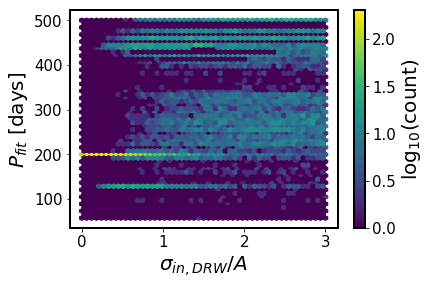

In [221]:
col0 = res_dic['withFAP']['fAvals']
col1 = res_dic['withFAP']['Pfit']

plot = plt.hexbin(col0, col1,
           gridsize=50, bins='log')# ,c=)
plt.colorbar(plot, label=r'$\log_{10}{(\mathrm{count})}$')
plt.xlabel(r'$\sigma_{in, DRW}  / A$')
plt.ylabel(r'$P_{fit}$'+' [days]')
plt.savefig('_setup1c_N-SDSS_vary_fA.png', bbox_inches='tight')

Then, vary the period as a function of baseline, keeping the amplitude ratio fixed at 1, and the same period bounds as above  ( also try keeping at 0.5 ) :

2236.9155282100182

In [263]:

# Try setup 1c, with limits from 20 to 500 : 
import time
res_dic = {'withFAP':{}}

# Setup 1 : narrow period range 
#minimum_period, maximum_period = 100, 250 

# Setup 1a : wider period range 
minimum_period, maximum_period = 20, 500

# Setup 2: wide period range 
#minimum_period, maximum_period = 0.01, 1000

Niterations = 100
verbose = False

# Keeping the random number generator seed the same, 
# so that the only thing that changes is the number of points 
baseline = t.max() - t.min()
fBaseline = np.linspace(0.001,0.5,100)
keyFAP = 'withFAP'

# initialize the temporary storage arrays :  ensures
# there is no overhead, as adding to a list is very quck ,
# unlike numpy.append() as far as I know 
Pfit = []
texec = []
fBaseVals = []
pValues = []
FAP = []
for i in range(Niterations):
    print('### iteration  ', i)
    for fBase in fBaseline : 
        fBaseVals.append(fBase)
        period = baseline * fBase
        pValues.append(period)
        
        y_err = np.random.uniform(0.01, 0.02, len(t))
        #(t,y_err,A=1,period=200,mean=15, fP=1, fA=1)
        y_obs = model_sin_drw(t,y_err, period=period, fA = 1) # S82 cadence
    
        # fitting for best period using Gatspy 
        start = time.time()

        # fap_calc is None if returnFAP is False 
        fit_period, fap_calc = fit_astropy(t,y_obs,y_err, 
                                returnFAP=returnFAP,
                                minimum_frequency = 1/maximum_period,  
                                maximum_frequency = 1/minimum_period)

        end = time.time()
        dt = end  - start 

        Pfit.append(fit_period)
        FAP.append(fap_calc)
        texec.append(dt)
        if verbose:
            print(keyFAP, N, i, fit_period,fap_calc,dt*1000)
    # store in dict
    res_dic[keyFAP]['Pfit'] = Pfit
    res_dic[keyFAP]['texec'] = texec
    res_dic[keyFAP]['fBaseVals'] = fBaseVals
    res_dic[keyFAP]['pValues'] = pValues
    res_dic[keyFAP]['FAP'] = FAP
print('/n')   
print('####### DONE #######  : ', keyFAP)



        
        
        

### iteration   0
### iteration   1
### iteration   2
### iteration   3
### iteration   4
### iteration   5
### iteration   6
### iteration   7
### iteration   8
### iteration   9
### iteration   10
### iteration   11
### iteration   12
### iteration   13
### iteration   14
### iteration   15
### iteration   16
### iteration   17
### iteration   18
### iteration   19
### iteration   20
### iteration   21
### iteration   22
### iteration   23
### iteration   24
### iteration   25
### iteration   26
### iteration   27
### iteration   28
### iteration   29
### iteration   30
### iteration   31
### iteration   32
### iteration   33
### iteration   34
### iteration   35
### iteration   36
### iteration   37
### iteration   38
### iteration   39
### iteration   40
### iteration   41
### iteration   42
### iteration   43
### iteration   44
### iteration   45
### iteration   46
### iteration   47
### iteration   48
### iteration   49
### iteration   50
### iteration   51
### iteration   52
###

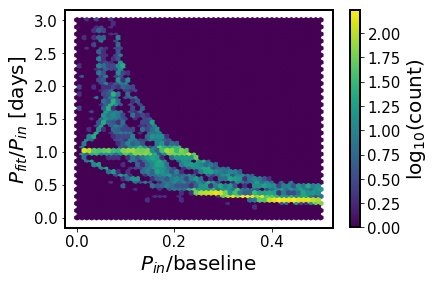

In [264]:
col0 = res_dic['withFAP']['fBaseVals']
col1 = np.array(res_dic['withFAP']['Pfit']) / np.array(res_dic[keyFAP]['pValues'])

plot = plt.hexbin(col0, col1,
           gridsize=50, bins='log',
                 extent=(min(col0), max(col0), 0,3))# ,c=)
plt.colorbar(plot, label=r'$\log_{10}{(\mathrm{count})}$')
plt.xlabel(r'$P_{in}  / \mathrm{baseline} $')
plt.ylabel(r'$P_{fit}/P_{in}$'+' [days]')
plt.savefig('_setup1c_N-SDSS_vary_Period_fA-1_ratios.png', bbox_inches='tight')

In [260]:
plt.hexbin?

Plot some values below for illustration : 

0.001 2.23691552821
277.057509945
0.0564444444444 126.261454259
277.057509945
0.111888888889 250.28599299
277.057509945
0.167333333333 374.31053172
277.057509945
0.222777777778 498.335070451
277.057509945
0.278222222222 622.359609182
277.057509945
0.333666666667 746.384147913
277.057509945
0.389111111111 870.408686643
277.057509945
0.444555555556 994.433225374
277.057509945
0.5 1118.45776411
277.057509945


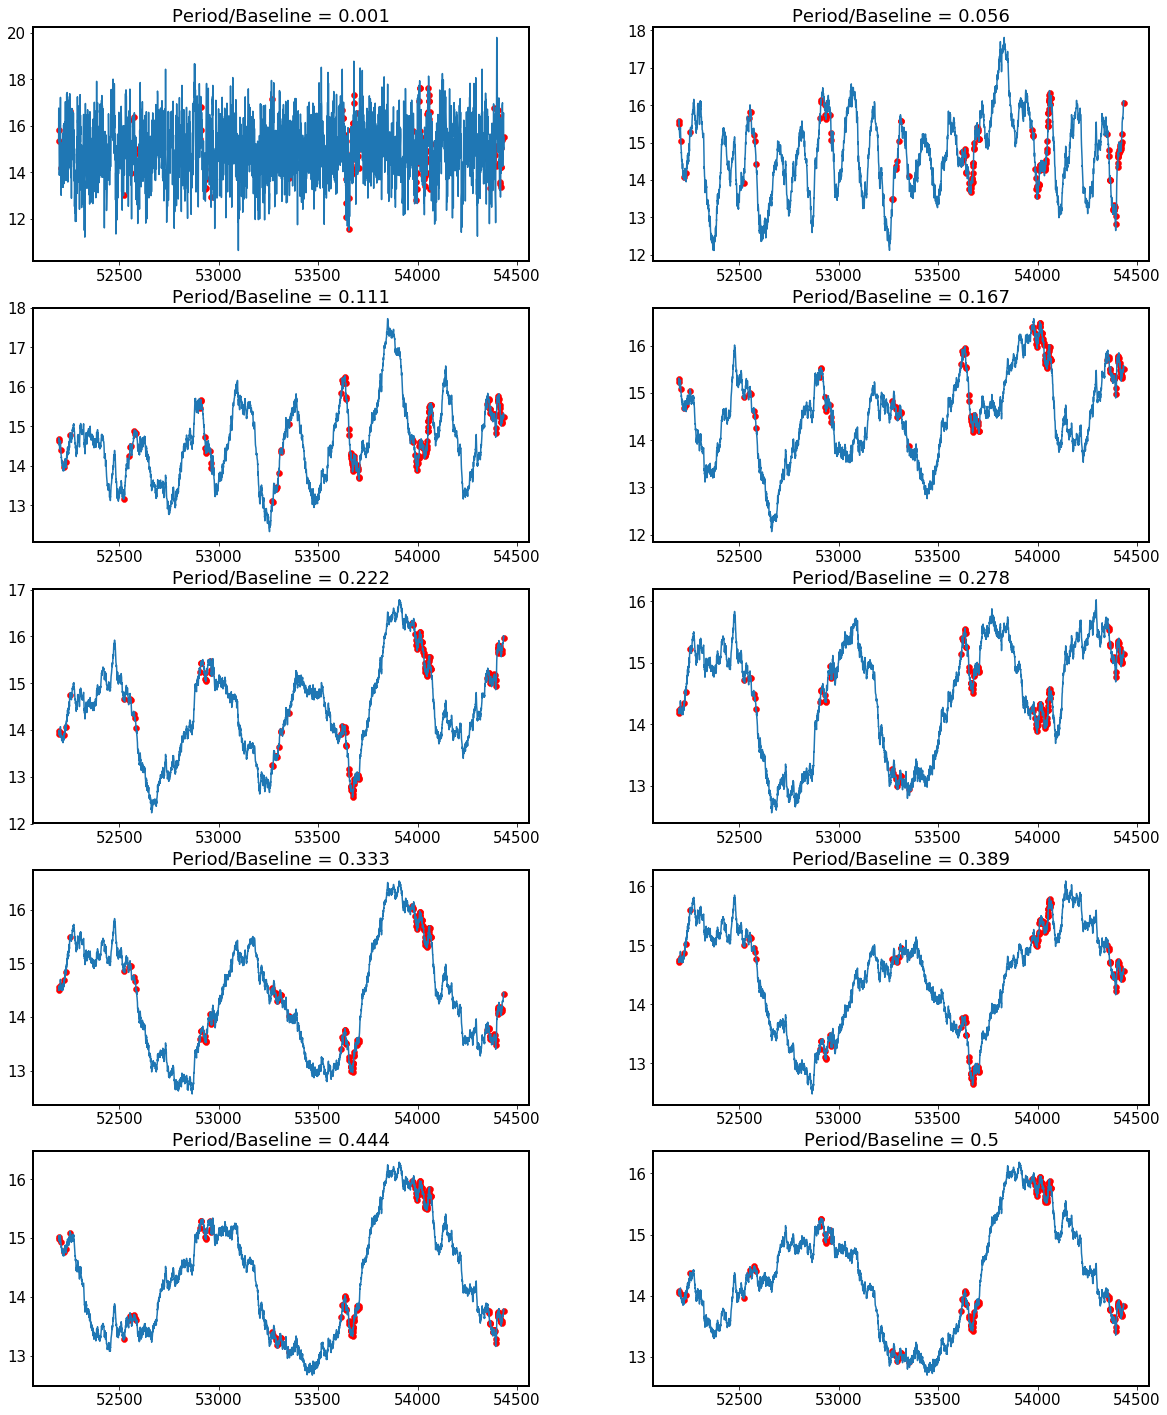

In [255]:
# Plot some values ....

baseline = t.max() - t.min()
fBaseline = np.linspace(0.001,0.5,10)

fig,axs = plt.subplots(5,2, figsize=(20,25))
ax = np.ravel(axs)
i=0
for fBase in fBaseline : 

    period = baseline * fBase
    print(fBase, period)
    np.random.seed(41)
    #y_err = np.random.uniform(0.01, 0.02, len(t))
    #y_obs = model_sin_drw(t,y_err, period=period) # S82 cadence
    # model at much higher cadence, but then sample 
    # only at SDSS S82 cadence
    t_model = np.sort(np.random.uniform(min(t), max(t), 5000))
    y_err_model = np.random.uniform(0.01, 0.02, len(t_model))
    y_model = model_sin_drw(t_model, y_err_model, period=period ) # much better cadence 
    y_obs_interp = np.interp(t, t_model, y_model)
    #ax[i].scatter(t,y_obs)
    ax[i].plot(t_model ,y_model )  # impeccable 'model' cadence 
    ax[i].scatter(t, y_obs_interp, c='red', lw=0.5) # S82 cadence 
    ax[i].set_title('Period/Baseline = '+str(fBase)[:5])
    # fap_calc is None if returnFAP is False 
    fit_period, fap_calc = fit_astropy(t,y_obs,y_err, 
                            returnFAP=returnFAP,
                            minimum_frequency = 1/maximum_period,  
                            maximum_frequency = 1/minimum_period)
    print(fit_period)
    i += 1 
fig.subplots_adjust(wspace=0.25)

In [241]:
np.random.uniform(0,10,100)

array([ 6.28166752,  4.88499608,  8.88707447,  1.12632204,  0.9472778 ,
        8.94148931,  3.26914747,  1.76723911,  0.04864708,  2.94756567,
        4.46179261,  7.45505212,  9.41458256,  2.57203232,  5.61172289,
        5.73197407,  4.3108784 ,  3.01249873,  1.16539406,  3.76222961,
        6.51861742,  4.07796335,  0.44400616,  3.09457709,  3.10332125,
        6.58527809,  7.57459602,  4.35099261,  0.25896379,  7.70021342,
        7.88848767,  4.48350828,  5.0993507 ,  7.51697247,  0.12486009,
        4.0594923 ,  6.75252186,  1.38840227,  9.50160486,  7.53646711,
        9.02895895,  5.44976723,  4.69203478,  9.67899456,  7.05883022,
        5.14476276,  7.82256931,  0.73004021,  9.42637712,  0.8867093 ,
        2.47614305,  4.7019878 ,  8.99593218,  1.06351017,  4.38246519,
        3.18398486,  1.36384894,  6.11096847,  8.26078487,  2.35649057,
        5.91033357,  3.60768379,  2.94266561,  1.27062476,  0.25373803,
        1.8062079 ,  0.87103197,  8.98444024,  1.91846629,  2.43

best period is  226.5499090908143
fap for this period is  2.287456334109633e-19


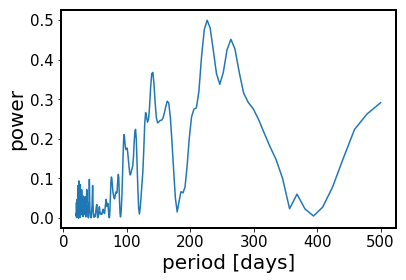

In [207]:
# Let's see how LS can recover the true period ... 

# calculate LS
ls = LombScargle(t, mag, dmag, normalization='standard')

minimum_period = 20 ;   maximum_period = 500
freq, power = ls.autopower(minimum_frequency=1 / maximum_period,
                               maximum_frequency=1 / minimum_period)
plt.xlabel('period [days]')
plt.ylabel('power')
plt.plot(1 / freq, power)
best_freq = freq[np.argmax(power)]
best_period = 1.0 / best_freq
print('best period is ', best_period)
fap = ls.false_alarm_probability(power.max())
print('fap for this period is ', fap)

best period is  917.9290387029107
fap for this period is  1.2846981232329501e-22


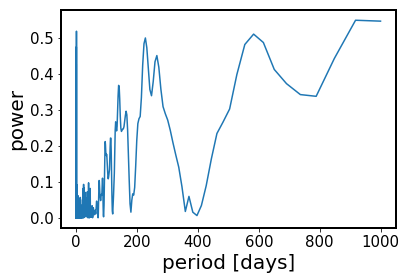

In [206]:
# Let's see how LS can recover the true period ... 

# calculate LS
ls = LombScargle(t, mag, dmag, normalization='standard')

minimum_period = 0.01 ;   maximum_period = 1000
freq, power = ls.autopower(minimum_frequency=1 / maximum_period,
                               maximum_frequency=1 / minimum_period)
plt.xlabel('period [days]')
plt.ylabel('power')
plt.plot(1 / freq, power)
best_freq = freq[np.argmax(power)]
best_period = 1.0 / best_freq
print('best period is ', best_period)
fap = ls.false_alarm_probability(power.max())
print('fap for this period is ', fap)

best period is  438.6108878843172
fap for this period is  3.0374282422238763e-28


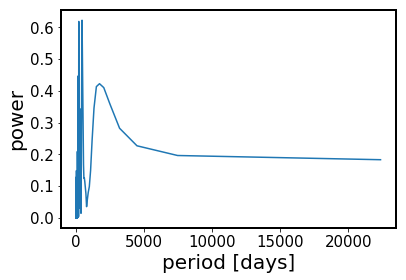

In [143]:
# Let's see how LS can recover the true period ... 

# calculate LS
ls = LombScargle(t82, mag, dmag, normalization='standard')

freq, power = ls.autopower(minimum_frequency=None,
                               maximum_frequency=None)
plt.xlabel('period [days]')
plt.ylabel('power')
plt.plot(1 / freq, power)
best_freq = freq[np.argmax(power)]
best_period = 1.0 / best_freq
print('best period is ', best_period)
fap = ls.false_alarm_probability(power.max())
print('fap for this period is ', fap)

Pretty  good, but clearly, the wider frequency range we allow, the longer each execution takes. 

Check how long : 

In [ ]:
len*

### Minimum amplitude , AstroPy LS with frequency limits, well sampled

Now , test whats the minimum amplitude to start picking up the correct period ... ( For fixed SF_infty)

####### DONE ####### 


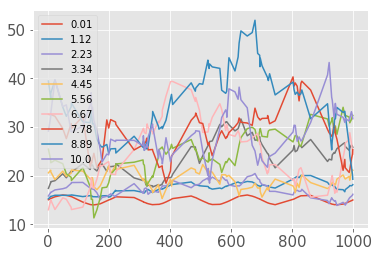

In [109]:
N = 100
A = 1 
period = 200
mean = 15
t = np.sort(np.random.uniform(0, 1000, N)) 
y_err = np.random.uniform(0.01, 0.02, len(t))
# Trial 2 : calculate  FAP for each light curve as well as best period 

np.random.seed(41)  # Keeping the random number generator seed the same, 

Pfit = []
fAvals = []
FAP = []


# SF_inf = fA * A   -- >  fA =  SF_inf / A 
# thus for constant A  = 1  , 
# by increasing fA we are increasing SF_inf.  

# for small fA,   SF_inf is very small compared to 
# sinusoidal amplitude of oscillation

i = 0 
for fA in np.linspace(0.01,10, 10) : 
    fAvals.append(fA)
    y_obs = model_sin_drw(t,y_err,A=A,period=period,mean=mean, fP=1, fA=fA)
    plt.plot(t,y_obs+i, label=fA)
    fit_period, fap_calc = fit_astropy(t,y_obs,y_err, returnFAP=True)
    Pfit.append(fit_period)
    FAP.append(fap_calc)
    i += 2
plt.legend()
print('####### DONE ####### ')




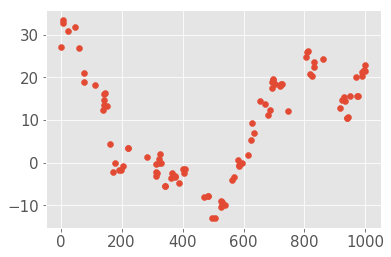

In [106]:
A = 1 
fA = 10
y_obs = model_sin_drw(t,y_err,A=A,period=period,mean=mean, fP=1, fA=fA)
plt.scatter(t,y_obs)

In [ ]:
Tests : 

### Benchmark  Celerite sinusoidal-period detection : accuracy and time 


In [278]:
period

200

In [293]:


# Wrap the fitting part 
def fit_celerite_sinusoid(t, y_obs,y_err ):
    # Here's how to compute the periodogram using a celerite noise model:
    A_tmp = np.empty((len(t), 3))
    A_tmp[:, -1] = 1.0
    
    # custom likelihood functions
    def get_design_matrix(period,t):
            omega = 2*np.pi/period
            A_tmp[:, 0] = np.cos(omega*t)
            A_tmp[:, 1] = np.sin(omega*t)
            return A_tmp

    def get_weights(gp, period, y_obs):
        A = get_design_matrix(period,t)
        ATA = np.dot(A.T, gp.apply_inverse(A))
        ATy = np.dot(A.T, gp.apply_inverse(y_obs[:, None]))
        return A, np.linalg.solve(ATA, ATy)

    def get_optimized_loglike(gp, period, y_obs):
        A, w = get_weights(gp, period, y_obs)
        r = y_obs - np.dot(A, w)[:, 0]
        return gp.log_likelihood(r, quiet=True)

    # Define the celerite kernel for calculating 
    # optimized likelihood 
    # # <- note: this is the wrong kernel and it still works...
    kernel = terms.RealTerm(np.log(1.0), np.log(2.0*np.pi/200.0))  
    gp = celerite.GP(kernel)
    gp.compute(t, y_err)#, mean=np.mean(y_obs))

    # evaluate the custom likelihood 
    periods = np.exp(np.linspace(np.log(100), np.log(250.0), 1000))
    loglike = np.empty_like(periods)
    for i, p in enumerate(periods):
        loglike[i] = get_optimized_loglike(gp, p, y_obs)

    # Then optimize from the maximum period
    def cost(params):
        period = np.exp(params[0])
        gp.set_parameter_vector(params[1:])
        return -get_optimized_loglike(gp, period, y_obs)

    params = np.append(np.log(periods[np.argmax(loglike)]), 
                       gp.get_parameter_vector())
    soln = minimize(cost, params)
    gp.set_parameter_vector(soln.x[1:])
    #print(soln)

    period = np.exp(soln.x[0])
    _, w = get_weights(gp, period, y_obs)
    amp = np.sqrt(np.sum(w[:2]**2))
    #print(period, amp)
    
    return period

In [300]:
# Benchmarking Celerite fitting sinusoidal component

Pfit = []
texec = []
Nnum = []
Nvals  = np.arange(50,1500,50)

period = 200
A = 1

mean = 15 
np.random.seed(41)  # for reproducibility 

for i in range(5):
    for N in Nvals : 
        Nnum.append(N)
        t = np.sort(np.random.uniform(0, 1000, N))  
        # the photometric errors drawn from uniform distribution
        # between lower and upper noise value 
        # those correspond to very low noise 
        y_err = np.random.uniform(0.01, 0.02, len(t))
        # noise = yerr * np.random.randn(len(t)) 
        y_obs = model_sin_drw(t,y_err)
        # fitting for best period using Gatspy 
        start = time.time()
        fit_period = fit_celerite_sinusoid(t, y_obs,y_err )
        end = time.time()
        dt = end  - start 

        Pfit.append(fit_period)
        texec.append(dt)
print('####### DONE ####### ')

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/optimize/optimize.py:964: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


LinAlgError: Singular matrix

In [304]:
len(Nnum)

52

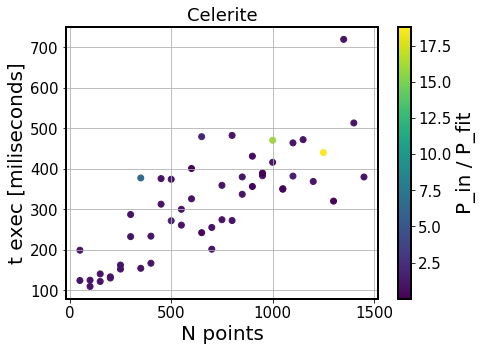

In [306]:
fig,ax = plt.subplots(1,1, figsize=(7,5))
ax.set_title('Celerite')
ax.set_xlabel('N points')
ax.set_ylabel('t exec [miliseconds]')
cbar = ax.scatter(Nnum[:-1], np.array(texec)*1000, c=200/np.array(Pfit))
plt.colorbar(cbar, label = 'P_in / P_fit')
ax.grid()
plt.savefig('Celerite_sinusoid_with_DRW_benchmark.png', bbox_inches='tight')

In [ ]:
# Implement false alarm probability 



In [307]:
from gatspy.periodic import LombScargleMultiband
LombScargleMultiband??

In [317]:
# try using the real data for one of the S82 carbon stars : 
# after all it's non-simultaneous multi-band SDSS data 

fname = os.listdir('../../SDSS_S82_FP_research/code/Stripe82_dCs_lc/')[0]
lc = Table.read('../../SDSS_S82_FP_research/code/Stripe82_dCs_lc/'+fname , format='ascii')


In [324]:
t,y,dy, filts = lc['mjd'], lc['psfMagDered'], lc['psfMagErr'], lc['filter']

In [332]:
ls = LombScargleMultiband(Nterms_band=3).fit(t, y, dy,filts)
ls.optimizer.period_range = (100,250)
ls.best_period

Finding optimal frequency:
 - Estimated peak width = 0.00281
 - Using 5 steps per peak; omega_step = 0.000562
 - User-specified period range:  99 to 2.5e+02
 - Computing periods at 69 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/gatspy/periodic/_least_squares_mixin.py:33: RuntimeWarning: divide by zero encountered in true_divide
  return np.average(y, weights=1 / dy ** 2)
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/lib/function_base.py:1142: RuntimeWarning: invalid value encountered in double_scalars
  avg = np.multiply(a, wgt, dtype=result_dtype).sum(axis)/scl
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/gatspy/periodic/lomb_scargle_multiband.py:133: RuntimeWarning: divide by zero encountered in true_divide
  return np.transpose(np.vstack(cols) / dy)
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/gatspy/periodic/lomb_scargle_multiband.py:133: RuntimeWarning: invalid value encountered in true_divide
  return np.transpose(np.vstack(cols) / dy)


255.71580423564203

In [ ]:
model  = ls.

In [330]:
ls.optimizer.best_period(model)